<font color="red" size=4>Kaggle competition **Tabular Playground Series - May 2022** final solution kernel</font>
- May 2022 PLayground competition was binary classificationbased on tabular data, 
- My personal goal was to evaluate two implementations of neutal network dedicated to solve tabular data problems
> - the first TabNet implementation was based on Tensorflow framework
> - the second - Torch framework
- I was interested in several aspects of comparison, but especially:
> - the results in comparison with my favourite tools used for this kind of problem 
<br>(one of gradient boosting solutions (XGBoost/LightGBM/CatBoost))
> - the comparison working speed of Tensorflow and Torch implmentation

Theere were train data composed of 900 000 records and test data (700 000).
The features were:
- in some part numerical (float and continuous), 
- in come - categorical (with 2 to 16 levels) 
- one more complex feature, 30 of them all over.

This script contains the final solution, composed of traiing and prediction using:
1. Tensorflow TabNet implementation
2. PyTorch TabNet implementation
3. XGB, LightGBM and CatBoost implementation

The final conclusion is:
- **On overall, any of tested TabNet implementation performs better than boosters**
- **The price of this performance improvement one must accept to pay**  is much longer time of neural based solution training 

The final score I achieved during the competition was 0.99810 in comparison to 0.99833 winning value

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="1"
import numpy as np
import pandas as pd
import itertools
import warnings
import lightgbm
import sklearn
import xgboost
import catboost
import matplotlib.ticker as ticker
import datetime as dt
from tabulate import tabulate
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tabnet.models.classify import TabNetClassifier as TFTabnetClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tabnet.schedules import DecayWithWarmupSchedule
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from pytorch_tabnet.tab_model import TabNetClassifier as TorchTabnetClassifier
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

for m in [pd,sklearn,xgboost, catboost, lightgbm, tf, torch]:
    print(f"{m.__name__}: {m.__version__}")
    
pd.options.display.max_columns=0
warnings.filterwarnings('ignore')

2022-06-01 21:58:49.135435: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


pandas: 1.4.2
sklearn: 1.0.2
xgboost: 1.6.0
catboost: 1.0.5
lightgbm: 3.3.2
tensorflow: 2.4.0
torch: 1.10.1+cu102


# Data preparation

## Loading

In [2]:
# Oryginal Kaggle csv converted to pickle to save space
# visit https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data

SRCTRAIN="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/train.pkl"
SRCTEST="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/test.pkl"

train_df = pd.read_pickle(SRCTRAIN)
test_df = pd.read_pickle(SRCTEST)

df=train_df.append(test_df)
target=df['target']
df=df.iloc[:,:-1]

In [3]:
train_df.head()


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


## F27 decomposition

### Pattern distance

In [5]:
z_distance_data_cols = [f"f_27_{i+1}" for i in range(10)]
z_distance_data = pd.DataFrame(df['f_27'].apply(list).tolist(), columns=z_distance_data_cols)
for feature in z_distance_data_cols:
    z_distance_data[feature] = z_distance_data[feature].apply(lambda x: ord('Z') - ord(x))
z_distance_data.head()

,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10
0,25,24,25,24,22,25,22,24,25,24
1,25,23,25,23,23,25,22,23,21,24
2,25,25,25,21,25,24,23,15,25,22
3,24,22,24,24,25,25,23,24,23,24
4,24,22,24,23,24,24,23,18,20,21


In [6]:
df=df.join(z_distance_data)

## Other features

In [7]:
df['f_27_uc'] = df['f_27'].apply(lambda x : len(set(x)))


## Interaction features

In [8]:
df["f_02_f_21_sum_hist"] = df.apply(lambda r: 1 if (r['f_02']+r['f_21'])<-5.3 else 2 if (r['f_02']+r['f_21'])>5.2 else 0, axis=1)
df["f_05_f_22_sum_hist"] = df.apply(lambda r: 1 if (r['f_05']+r['f_22'])<-5.4 else 2 if (r['f_05']+r['f_22'])>5.1 else 0, axis=1)
df["f_00_01_26"] = df.apply(lambda r: 2 if (r['f_00']+r['f_01']+r["f_26"])<-5 else 1 if (r['f_00']+r['f_01']+r["f_26"])>5 else 0 , axis=1)

## Final dataset

In [9]:
df=df.join(target)
del df['f_27']

In [10]:
print(df.shape)
df.head()

(1600000, 45)


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10,f_27_uc,f_02_f_21_sum_hist,f_05_f_22_sum_hist,f_00_01_26,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0,25,24,25,24,22,25,22,24,25,24,3,0,0,0,0.0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0,25,23,25,23,23,25,22,23,21,24,5,0,0,0,1.0
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2,25,25,25,21,25,24,23,15,25,22,6,0,0,0,1.0
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0,24,22,24,24,25,25,23,24,23,24,4,0,0,0,1.0
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1,24,22,24,23,24,24,23,18,20,21,6,0,0,1,1.0


In [11]:
train_df=df.loc[pd.isna(df['target'])==False,:]
train_df['target']=train_df['target'].astype(int)
test_df=df.loc[pd.isna(df['target'])==True,:].iloc[:,:-1]
print(train_df.shape)
print(test_df.shape)

(900000, 45)
(700000, 44)


## Data crossvalidation

In [11]:
NUM_SPLITS=10
skf = StratifiedKFold(n_splits=NUM_SPLITS)
folds = dict()
folds_results = dict()


idx = 0
train_data=train_df.iloc[:,:-1]
train_labels=train_df.iloc[:,-1]

for split in skf.split(train_data, train_labels ):
    folds[idx] = {'X_train': train_data.iloc[split[0],:], 
                  'y_train':  train_labels.iloc[split[0]], 
                  'X_val': train_data.iloc[split[1],:], 
                  'y_val':  train_labels.iloc[split[1]]
                  }
    print(f"Fold: {idx}, X_train {folds[idx]['X_train'].shape}, X_val {folds[idx]['X_val'].shape}")
    idx+=1

Fold: 0, X_train (810000, 44), X_val (90000, 44)
Fold: 1, X_train (810000, 44), X_val (90000, 44)
Fold: 2, X_train (810000, 44), X_val (90000, 44)
Fold: 3, X_train (810000, 44), X_val (90000, 44)
Fold: 4, X_train (810000, 44), X_val (90000, 44)
Fold: 5, X_train (810000, 44), X_val (90000, 44)
Fold: 6, X_train (810000, 44), X_val (90000, 44)
Fold: 7, X_train (810000, 44), X_val (90000, 44)
Fold: 8, X_train (810000, 44), X_val (90000, 44)
Fold: 9, X_train (810000, 44), X_val (90000, 44)


In [12]:
# store folds for future use with various models

with open('crossvalidated_10_folds.pkl', "wb") as f:
    pickle.dump(folds, f)

# Tensorflow TabNet prediction
- this is slightly modified Tensorflow TabNet implementation, made by Olivier St-Amand, see <a href=https://github.com/ostamand/tensorflow-tabnet>this GitHub repo</a>
- good <a href=https://www.kaggle.com/code/marcusgawronsky/tabnet-in-tensorflow-2-0/notebook>text on TabNet implementation in Tensorflow</a>


## Params definition

In [13]:
# The parameters were determined using 80 iterations of simulated anneal, non-crossvalidated, preserving only data proportion

params = {
  "max_epochs": 1000,
  "validation_fraction": 0.1,
  "early_stopping_rounds": 10,
  "tabnet_feature_dim": 40,
  "tabnet_output_dim": 32,
  "tabnet_n_step": 3,
  "relaxation_factor": 1.623339750566143,
  "tabnet_bn_momentum": 0.8058338198783632,
  "tabnet_dp": 0.,
  "initial_learning_rate": 0.04,
  "num_warmup_epochs": 7,
  "tabnet_bn_virtual_divider": 1,
  "lr_decay_rate": 0.8018089123605378,
  "decay_steps": 700,
  "min_learning_rate": 0.000001,
  "adam_clipnorm": 2.2582474516246567,
  "batch_size": 2048
}

## CV folds training

In [14]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results = dict()
test_predictions=dict()
folds_scores={}

In [19]:
# compute predicitons for each fold using TabNet - performed separately from other models
start=dt.datetime.now()

# supporting class for extended reporting
# a convenient way to report epochs to MLFlow or Microsoft NNI
class AUCCallback(Callback):
    def __init__(self, validation_data, validation_labels):
        self.x = validation_data
        self.y = validation_labels
        self.print_header=True
        self.scores=dict()
        self.history=dict()
        self.start=dt.datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x)
        auc = roc_auc_score(self.y.values, y_pred[:, 1])
        if self.print_header:
            print("No:\tTrain ACC:\tTrain loss:\tVal ACC:\tVal loss:\tVal AUC:\tDuration:")
            self.print_header=False
        print(f"{epoch}\t{logs['accuracy']:.6f}\t{logs['loss']:.6f}\t{logs['val_accuracy']:.6f}\t{logs['val_loss']:.6f}\t{auc:.6f}\t{dt.datetime.now()-self.start}")
        logs['AUC']=auc
        self.scores[epoch]=auc
        self.history[epoch]={'loss':logs['loss'], 'accuracy':logs['accuracy'],
                             'val_loss': logs['val_loss'], 'val_accuracy':logs['val_accuracy'], 'val_auc':auc}
        return

### Training loop

In [43]:
def plot_training_history(training_history:dict):
    hdf=pd.DataFrame.from_dict(training_history, orient='index').reset_index()
    fig, ax=plt.subplots(1,2,figsize=(16,8), sharex = True)
    sns.lineplot(data=hdf, x='index', y='loss', ax=ax[0])
    sns.lineplot(data=hdf, x='index', y='val_loss', ax=ax[0])
    ax[0].set_title('Training and validation loss')
    ax[0].grid('both')
    ax[0].legend(['training loss','validation loss'])
    
    sns.lineplot(data=hdf, x='index', y='accuracy', ax=ax[1])
    sns.lineplot(data=hdf, x='index', y='val_accuracy', ax=ax[1])
    sns.lineplot(data=hdf, x='index', y='val_auc', ax=ax[1])
    ax[1].set_title('Accuracy and AUC')
    ax[1].grid('both')
    ax[1].legend(['training accuracy','validation accuracy', 'validation AUC'])
    
    plt.show()

Starting fold 0
Starting attempt 0 in fold 0
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.856069	0.307421	0.939256	0.157711	0.984859	0:00:27.330588
1	0.949430	0.130664	0.955922	0.116962	0.991503	0:00:49.034337
2	0.958685	0.108297	0.961489	0.102898	0.993593	0:01:10.643281
3	0.964780	0.092723	0.967578	0.086257	0.995327	0:01:32.349502
4	0.968280	0.083203	0.965656	0.093905	0.994756	0:01:54.022036
5	0.970577	0.077432	0.973211	0.071638	0.996717	0:02:15.632453
6	0.973231	0.069579	0.973433	0.069701	0.996946	0:02:37.349224
7	0.974859	0.065503	0.974800	0.067066	0.997159	0:02:59.049696
8	0.975348	0.064091	0.974633	0.066504	0.997210	0:03:20.740061
9	0.976006	0.062529	0.974622	0.066236	0.997248	0:03:42.310569
10	0.976390	0.061015	0.975400	0.064661	0.997364	0:04:03.864318
11	0.977053	0.059453	0.976156	0.063018	0.997494	0:04:25.514000
12	0.977426	0.058265	0.975900	0.063420	0.997480	0:04:47.230658
13	0.977788	0.057372	0.976456	0.062773	0.997534	0:05:09.056517
14	0.978177	0.0561

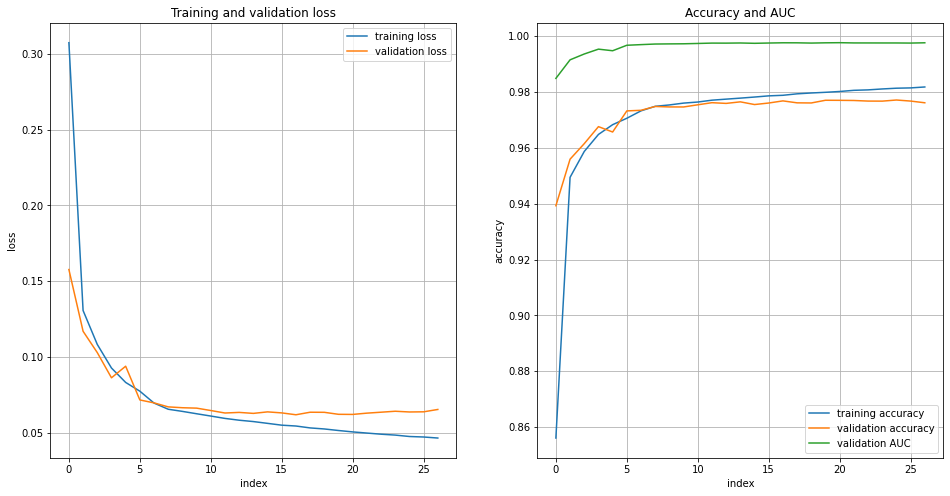

Starting attempt 1 in fold 0
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.855653	0.309844	0.927344	0.173893	0.982659	0:00:27.483699
1	0.943775	0.138030	0.954767	0.116462	0.991668	0:00:49.497358
2	0.958894	0.104950	0.965033	0.091097	0.994803	0:01:11.200833
3	0.963949	0.092008	0.966000	0.087804	0.995113	0:01:32.966366
4	0.967990	0.082275	0.969800	0.078126	0.996227	0:01:54.884611
5	0.970246	0.076409	0.970767	0.075585	0.996415	0:02:16.632489
6	0.971795	0.072619	0.971656	0.075389	0.996494	0:02:38.608996
7	0.972857	0.070461	0.971889	0.071835	0.996821	0:03:00.421590
8	0.973573	0.068157	0.973433	0.068601	0.997042	0:03:22.229272
9	0.974315	0.066018	0.974478	0.066266	0.997278	0:03:44.022359
10	0.975332	0.063746	0.974356	0.066564	0.997258	0:04:05.786824
11	0.975735	0.062609	0.974722	0.065258	0.997347	0:04:27.524708
12	0.976412	0.060944	0.975367	0.063783	0.997459	0:04:49.922190
13	0.976939	0.059378	0.975533	0.063949	0.997421	0:05:11.611671
14	0.977316	0.058846	0.975411	0.06

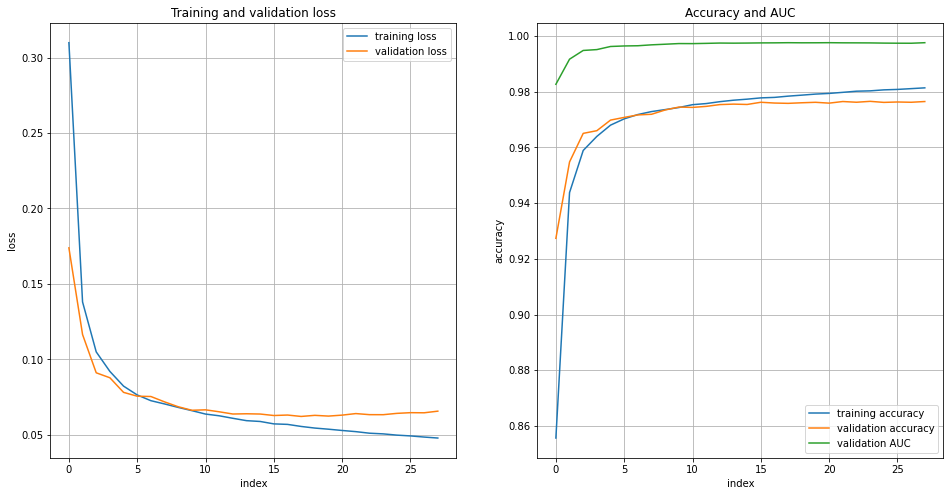

Starting attempt 2 in fold 0
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.851878	0.326741	0.933078	0.187467	0.979815	0:00:27.211369
1	0.940059	0.170675	0.939244	0.170019	0.981918	0:00:48.808954
2	0.953182	0.133893	0.957833	0.114040	0.991411	0:01:11.091173
3	0.960215	0.103677	0.963778	0.096891	0.993840	0:01:32.745929
4	0.965364	0.090740	0.967467	0.086417	0.995143	0:01:54.417211
5	0.967910	0.083866	0.968589	0.082840	0.995619	0:02:16.187238
6	0.969880	0.078748	0.969589	0.079098	0.995986	0:02:37.835060
7	0.971351	0.073101	0.971300	0.072894	0.996663	0:02:59.448212
8	0.972747	0.069598	0.972300	0.077322	0.995806	0:03:21.376793
9	0.973353	0.068178	0.971467	0.071971	0.997064	0:03:43.082967
10	0.974357	0.065340	0.974211	0.066288	0.997238	0:04:04.649919
11	0.975164	0.063229	0.974411	0.065566	0.997291	0:04:26.167638
12	0.975630	0.062049	0.974522	0.064831	0.997384	0:04:47.791056
13	0.976120	0.060777	0.973811	0.065345	0.997439	0:05:09.663205
14	0.976619	0.059665	0.975256	0.06

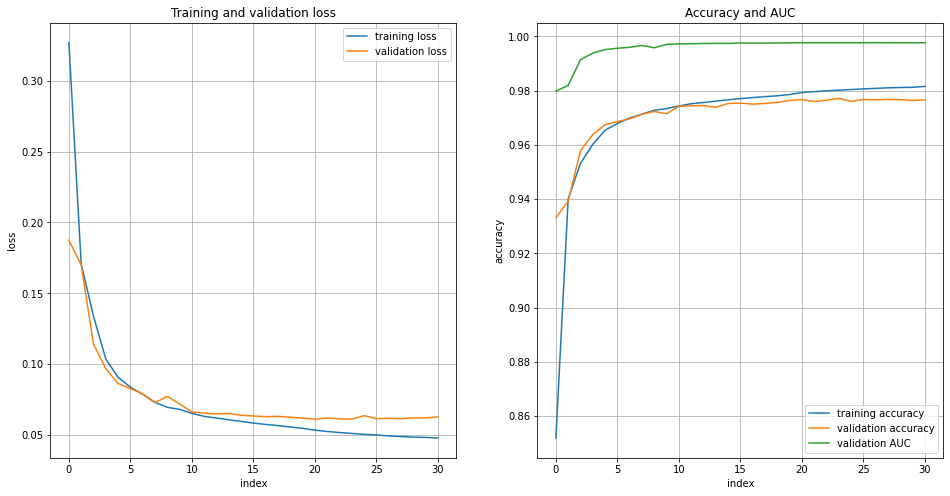

Performed fold 0 attempt 2
Starting fold 1
Starting attempt 0 in fold 1
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.852111	0.321889	0.929356	0.169921	0.982653	0:00:27.533670
1	0.944699	0.144151	0.947667	0.137855	0.988346	0:00:49.294392
2	0.954461	0.121969	0.952967	0.124355	0.991216	0:01:11.044592
3	0.957678	0.117532	0.957844	0.119949	0.991148	0:01:32.787488
4	0.960081	0.109218	0.961411	0.104920	0.992926	0:01:54.682042
5	0.963259	0.099916	0.965211	0.094956	0.994107	0:02:16.526714
6	0.967175	0.090502	0.967378	0.089950	0.994706	0:02:38.429767
7	0.969362	0.084296	0.968300	0.085745	0.995228	0:03:00.767460
8	0.971105	0.079692	0.970633	0.080235	0.995842	0:03:22.620678
9	0.972032	0.076932	0.969044	0.084244	0.995836	0:03:44.230578
10	0.973081	0.074121	0.971778	0.077663	0.996050	0:04:05.809480
11	0.972194	0.076958	0.965967	0.093670	0.994361	0:04:27.603752
12	0.971820	0.078594	0.971311	0.079309	0.995798	0:04:49.322462
13	0.973396	0.073880	0.972678	0.075724	0.996204	0:05:1

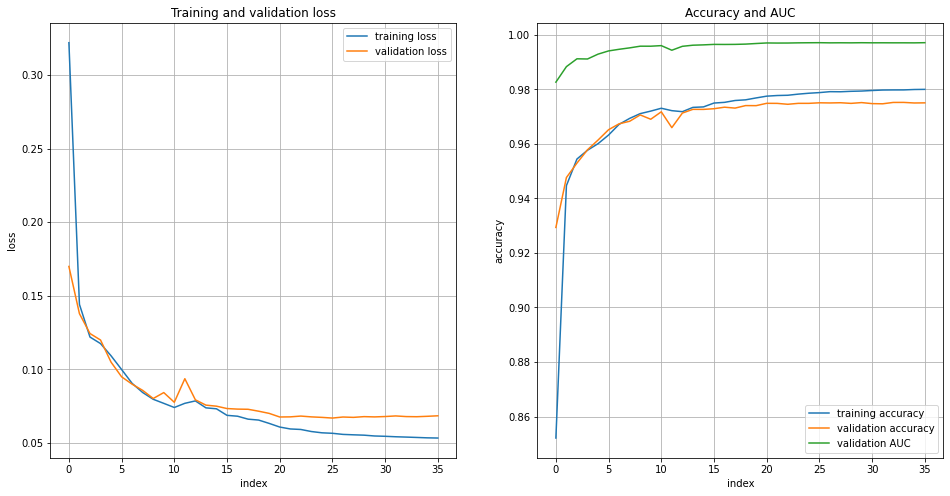

Starting attempt 1 in fold 1
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.841307	0.338641	0.927133	0.182584	0.979678	0:00:27.959673
1	0.941927	0.147797	0.954467	0.119181	0.991058	0:00:49.731402
2	0.958009	0.109344	0.960400	0.100932	0.993727	0:01:11.455272
3	0.963781	0.093782	0.965311	0.091435	0.994745	0:01:33.172956
4	0.967759	0.084491	0.966822	0.086950	0.995675	0:01:54.788509
5	0.968189	0.083821	0.970300	0.077804	0.996168	0:02:16.464773
6	0.971536	0.074690	0.971911	0.074155	0.996532	0:02:37.830158
7	0.972470	0.072277	0.969822	0.078791	0.996197	0:02:59.025373
8	0.973388	0.069779	0.972956	0.071549	0.996739	0:03:20.727507
9	0.974874	0.065576	0.973000	0.068637	0.997118	0:03:42.319042
10	0.975552	0.063156	0.974789	0.066407	0.997233	0:04:03.754852
11	0.976259	0.061297	0.974922	0.065646	0.997276	0:04:25.256011
12	0.977019	0.059782	0.974478	0.065908	0.997266	0:04:46.956594
13	0.976742	0.060211	0.974889	0.064914	0.997375	0:05:08.404462
14	0.977567	0.057837	0.975400	0.06

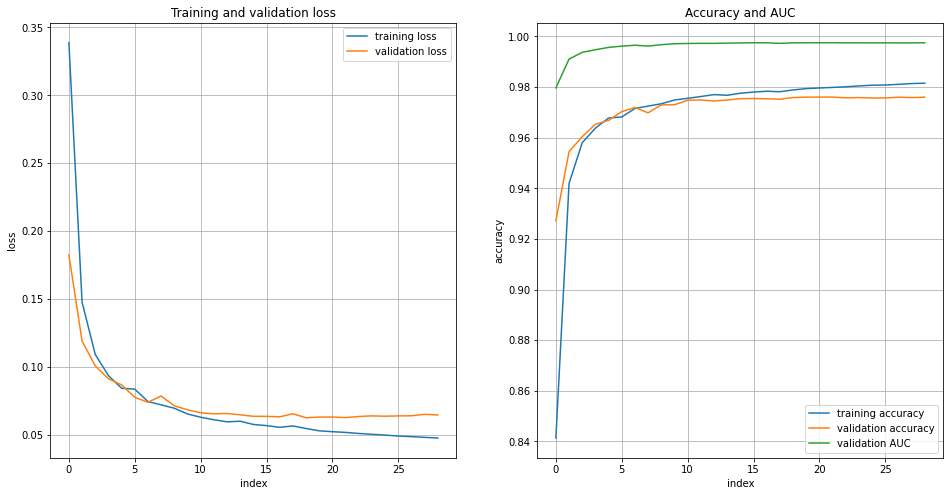

Starting attempt 2 in fold 1
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.848221	0.333408	0.921044	0.197818	0.976410	0:00:27.230385
1	0.926947	0.182881	0.927489	0.181701	0.984625	0:00:48.826077
2	0.944625	0.145644	0.950967	0.130917	0.989265	0:01:10.386029
3	0.952868	0.125580	0.944378	0.140262	0.987950	0:01:31.866607
4	0.956025	0.116653	0.956978	0.112370	0.992593	0:01:53.718825
5	0.959667	0.106734	0.959044	0.107635	0.993138	0:02:15.441848
6	0.962015	0.101518	0.957267	0.113941	0.992378	0:02:37.136545
7	0.962653	0.102084	0.965189	0.094955	0.994305	0:02:58.725150
8	0.965558	0.092642	0.966778	0.087676	0.995184	0:03:20.141493
9	0.968863	0.083222	0.967456	0.086497	0.995406	0:03:41.568534
10	0.970025	0.080645	0.969100	0.082151	0.995720	0:04:03.729397
11	0.971189	0.077602	0.970533	0.079317	0.996012	0:04:25.288031
12	0.972749	0.073176	0.972400	0.072846	0.996629	0:04:46.980979
13	0.973998	0.068992	0.972933	0.072036	0.996721	0:05:08.664182
14	0.974923	0.066607	0.973844	0.07

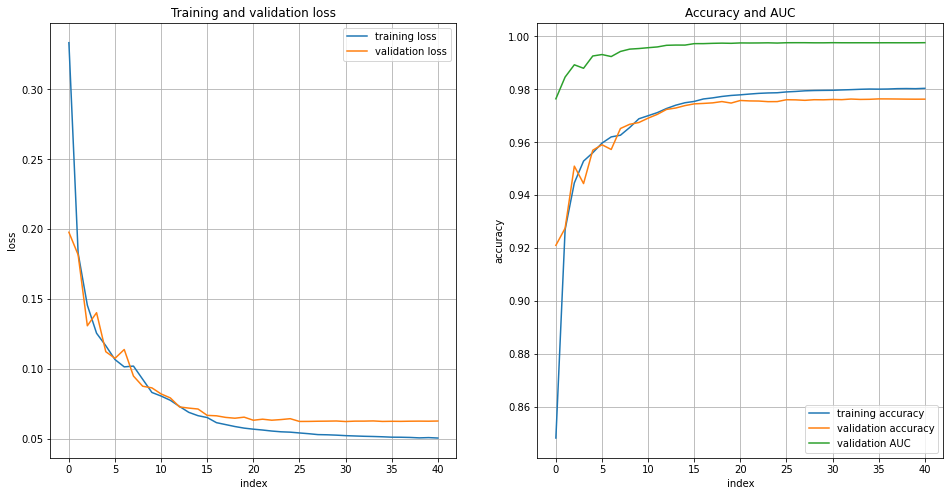

Performed fold 1 attempt 2
Starting fold 2
Starting attempt 0 in fold 2
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.875337	0.296244	0.923778	0.219079	0.971649	0:00:27.386164
1	0.940953	0.179331	0.946700	0.157253	0.983378	0:00:49.796136
2	0.949222	0.137402	0.953589	0.118704	0.991398	0:01:11.645278
3	0.956332	0.112455	0.958356	0.106935	0.992976	0:01:33.502012
4	0.960674	0.101750	0.962911	0.096994	0.994294	0:01:55.243880
5	0.964102	0.095432	0.965556	0.091122	0.994920	0:02:16.897716
6	0.967154	0.087258	0.968656	0.083361	0.995581	0:02:38.550542
7	0.969038	0.082402	0.969267	0.081387	0.995822	0:03:00.294756
8	0.967452	0.086577	0.968133	0.085513	0.995355	0:03:22.082783
9	0.971080	0.076054	0.970756	0.075805	0.996429	0:03:43.733651
10	0.973436	0.068608	0.973600	0.068109	0.997113	0:04:05.269196
11	0.974685	0.065948	0.972033	0.070542	0.996959	0:04:26.919713
12	0.974980	0.064228	0.974444	0.065931	0.997289	0:04:49.213273
13	0.975677	0.062805	0.974800	0.065534	0.997381	0:05:1

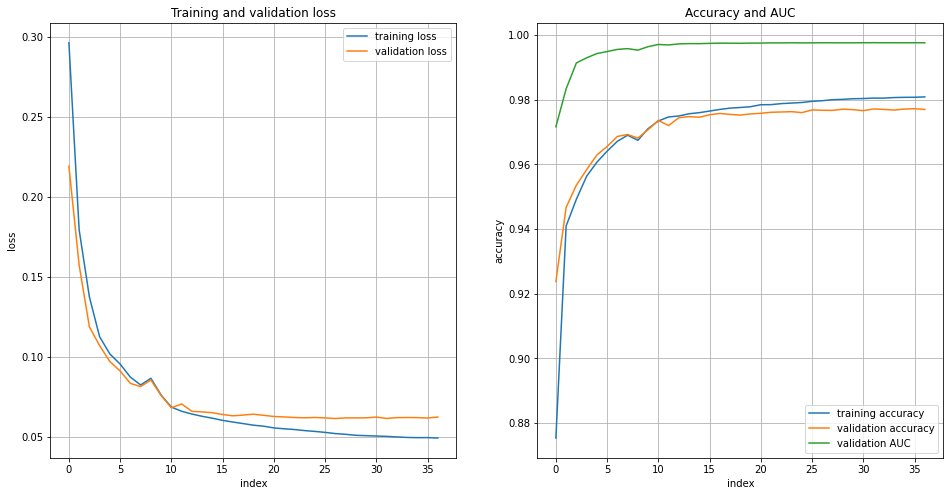

Starting attempt 1 in fold 2
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.860998	0.316357	0.928011	0.197787	0.977105	0:00:27.804755
1	0.933874	0.180477	0.939478	0.163733	0.984428	0:00:49.557657
2	0.942728	0.154832	0.932800	0.176882	0.982424	0:01:11.333824
3	0.944157	0.151466	0.946533	0.142241	0.987464	0:01:33.033238
4	0.950932	0.131149	0.951822	0.127043	0.990170	0:01:54.827675
5	0.946317	0.142152	0.923489	0.193885	0.977413	0:02:16.708864
6	0.950402	0.128720	0.945667	0.138490	0.990568	0:02:38.282128
7	0.956989	0.111488	0.957333	0.108553	0.992735	0:03:00.065816
8	0.956180	0.113721	0.949033	0.131769	0.992052	0:03:21.828395
9	0.959811	0.102325	0.961033	0.097817	0.994181	0:03:43.482646
10	0.963974	0.091776	0.963844	0.094410	0.994832	0:04:05.207092
11	0.967405	0.085861	0.967289	0.084638	0.995550	0:04:26.859686
12	0.968473	0.082881	0.968367	0.082426	0.995747	0:04:48.520639
13	0.970065	0.079242	0.968833	0.081284	0.995948	0:05:10.097374
14	0.970891	0.076621	0.970378	0.07

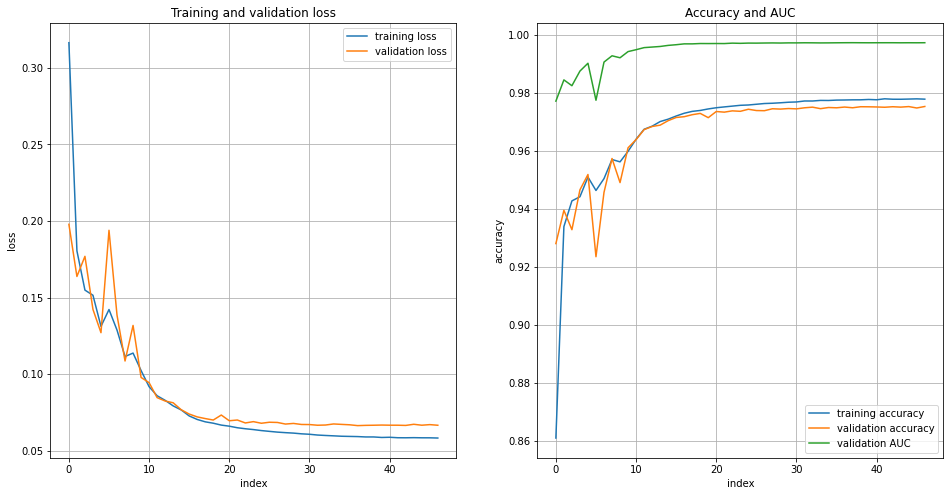

Starting attempt 2 in fold 2
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.865730	0.307916	0.917156	0.227843	0.968910	0:00:27.747359
1	0.937178	0.164153	0.948722	0.135402	0.988469	0:00:49.589727
2	0.953773	0.120161	0.954656	0.112190	0.992219	0:01:11.602350
3	0.958583	0.105493	0.961544	0.098653	0.993877	0:01:33.438423
4	0.959742	0.102831	0.962544	0.094950	0.994327	0:01:55.191862
5	0.963699	0.092525	0.966122	0.087500	0.995215	0:02:17.027582
6	0.966116	0.087413	0.965011	0.090825	0.994833	0:02:38.857262
7	0.967425	0.085366	0.966511	0.086083	0.995403	0:03:00.713593
8	0.968848	0.081258	0.967478	0.083528	0.995604	0:03:22.587771
9	0.970938	0.075984	0.971567	0.073435	0.996655	0:03:44.592136
10	0.972636	0.070738	0.973356	0.069232	0.997068	0:04:06.369400
11	0.973902	0.067178	0.973211	0.069163	0.997055	0:04:28.206126
12	0.974759	0.064727	0.974078	0.066542	0.997295	0:04:50.065611
13	0.975636	0.062560	0.974144	0.066011	0.997386	0:05:11.801726
14	0.975926	0.062155	0.974422	0.06

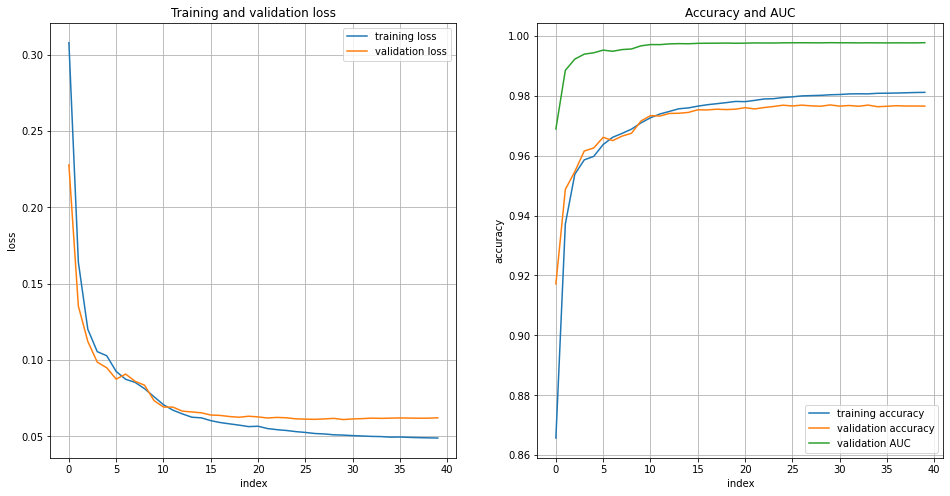

Performed fold 2 attempt 2
Starting fold 3
Starting attempt 0 in fold 3
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.871163	0.283515	0.945156	0.146816	0.986430	0:00:27.352594
1	0.946710	0.137594	0.950333	0.128689	0.989949	0:00:48.953760
2	0.954220	0.117560	0.957533	0.108469	0.992812	0:01:10.716991
3	0.959420	0.103104	0.961711	0.098043	0.993946	0:01:32.438046
4	0.963796	0.092468	0.964944	0.090421	0.995504	0:01:54.035893
5	0.968058	0.082129	0.970244	0.076246	0.996414	0:02:15.589673
6	0.970578	0.076218	0.971322	0.073279	0.996816	0:02:37.105352
7	0.972494	0.071739	0.973267	0.068765	0.997040	0:02:58.754539
8	0.973925	0.068192	0.974978	0.064651	0.997368	0:03:20.387652
9	0.974847	0.065504	0.974900	0.064908	0.997312	0:03:42.117750
10	0.975707	0.063535	0.974300	0.066329	0.997227	0:04:03.527831
11	0.976232	0.061858	0.975533	0.063924	0.997393	0:04:25.111740
12	0.976854	0.060299	0.975867	0.063387	0.997566	0:04:46.754521
13	0.977257	0.058869	0.975922	0.061458	0.997621	0:05:0

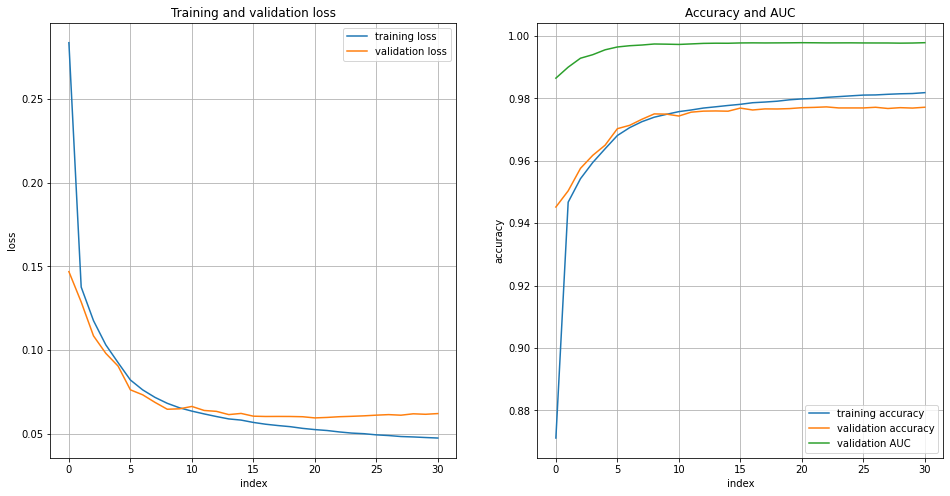

Starting attempt 1 in fold 3
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.868280	0.303290	0.923322	0.193604	0.977610	0:00:27.858700
1	0.936912	0.161915	0.946511	0.129980	0.989508	0:00:49.658144
2	0.948619	0.127392	0.952867	0.117054	0.991592	0:01:11.440344
3	0.959180	0.108328	0.962744	0.096412	0.994159	0:01:33.134514
4	0.965322	0.090979	0.966422	0.088290	0.995034	0:01:54.820138
5	0.967627	0.086087	0.968778	0.083351	0.995447	0:02:16.658665
6	0.969527	0.080023	0.970944	0.076560	0.996358	0:02:38.520024
7	0.971001	0.076609	0.970978	0.076216	0.996297	0:03:00.282776
8	0.972064	0.073581	0.972967	0.071015	0.996778	0:03:22.029893
9	0.970415	0.077586	0.971367	0.076086	0.996239	0:03:43.646238
10	0.973274	0.069938	0.973511	0.069708	0.996904	0:04:05.309711
11	0.974440	0.066606	0.973256	0.070097	0.996988	0:04:27.472966
12	0.975286	0.064791	0.974356	0.067248	0.997128	0:04:49.274332
13	0.976011	0.062987	0.975500	0.065647	0.997209	0:05:10.926828
14	0.976448	0.061688	0.974989	0.06

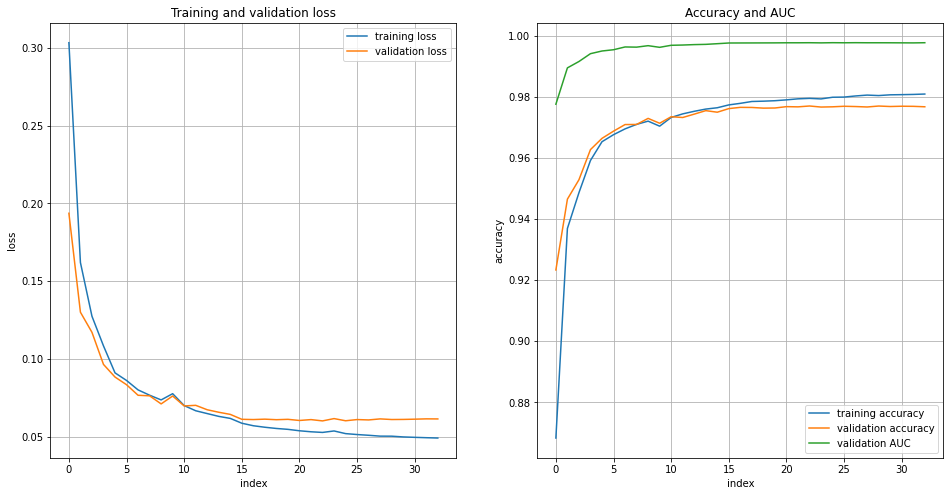

Starting attempt 2 in fold 3
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.874986	0.271716	0.941267	0.142311	0.988035	0:00:27.341275
1	0.948979	0.125619	0.956722	0.109469	0.993044	0:00:49.121635
2	0.961251	0.098823	0.964133	0.092538	0.994844	0:01:10.864701
3	0.968109	0.082276	0.969744	0.076849	0.996373	0:01:32.699339
4	0.970900	0.075342	0.971689	0.073249	0.996653	0:01:54.589995
5	0.972621	0.070721	0.972589	0.070575	0.996883	0:02:16.522099
6	0.973785	0.067397	0.971856	0.074865	0.996441	0:02:38.239184
7	0.974179	0.066824	0.974100	0.066590	0.997225	0:02:59.990327
8	0.975322	0.063892	0.973644	0.066817	0.997246	0:03:22.044528
9	0.976158	0.061762	0.975200	0.063753	0.997450	0:03:43.755362
10	0.976728	0.060126	0.975678	0.063039	0.997517	0:04:05.537782
11	0.977186	0.058946	0.975956	0.062363	0.997568	0:04:27.273962
12	0.977673	0.057576	0.975333	0.063597	0.997615	0:04:49.101072
13	0.978202	0.056492	0.975711	0.061912	0.997621	0:05:10.909935
14	0.978491	0.055650	0.976322	0.06

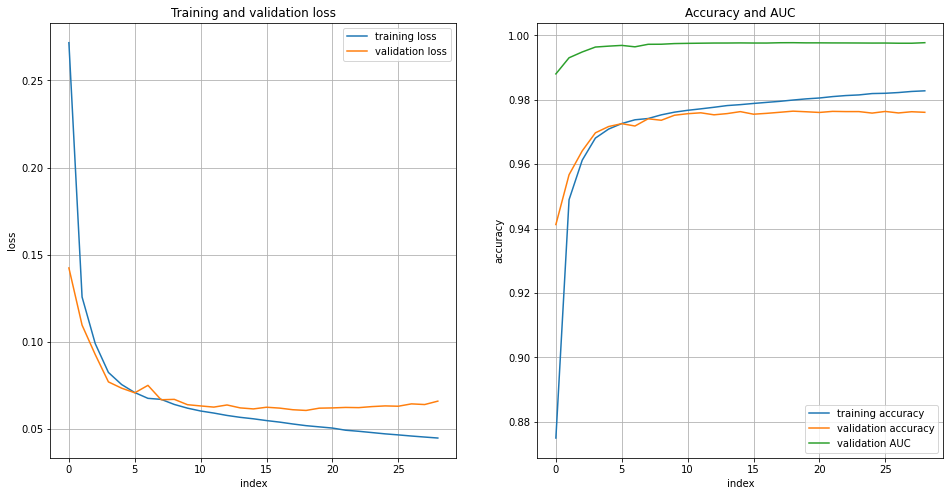

Performed fold 3 attempt 2
Starting fold 4
Starting attempt 0 in fold 4
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.864720	0.297660	0.935000	0.170657	0.981744	0:00:26.994904
1	0.947807	0.138891	0.954267	0.121886	0.990570	0:00:48.720663
2	0.957895	0.110814	0.958767	0.108999	0.992607	0:01:10.484309
3	0.964218	0.095661	0.966211	0.091725	0.994544	0:01:32.272092
4	0.967117	0.087637	0.966967	0.086729	0.995291	0:01:54.139245
5	0.969661	0.080408	0.969789	0.081013	0.996032	0:02:15.805764
6	0.971293	0.075197	0.973022	0.071211	0.996878	0:02:37.428381
7	0.973523	0.068771	0.972856	0.071255	0.996777	0:02:59.078420
8	0.974431	0.066434	0.973700	0.068379	0.997101	0:03:20.927157
9	0.975537	0.063390	0.974611	0.066394	0.997262	0:03:42.702037
10	0.976347	0.061099	0.975300	0.064778	0.997391	0:04:04.471449
11	0.976806	0.059864	0.975678	0.063331	0.997505	0:04:26.215793
12	0.977561	0.057814	0.975689	0.063527	0.997519	0:04:47.902895
13	0.977862	0.056867	0.975767	0.063014	0.997522	0:05:0

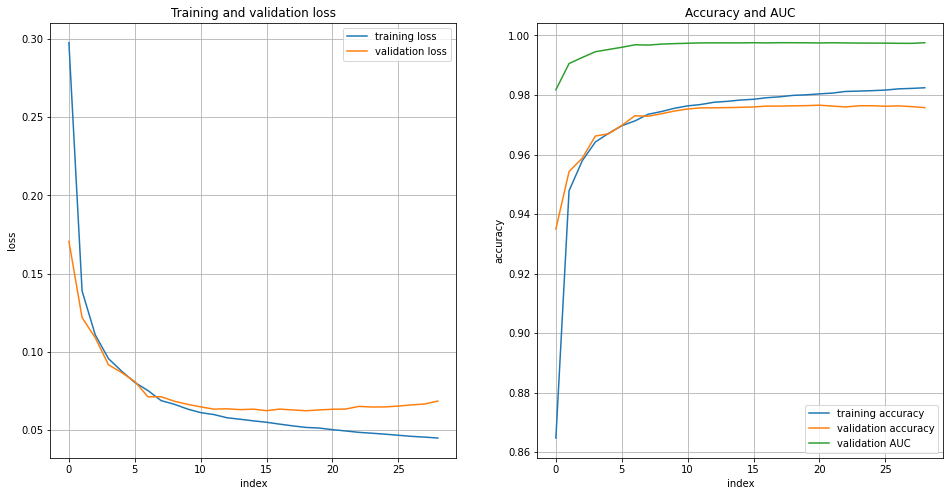

Starting attempt 1 in fold 4
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.861751	0.299265	0.934789	0.153179	0.986267	0:00:26.819100
1	0.946168	0.130045	0.951056	0.114971	0.992192	0:00:48.541510
2	0.959215	0.101769	0.964111	0.092277	0.994818	0:01:10.096069
3	0.965574	0.090188	0.965956	0.088801	0.995124	0:01:31.659672
4	0.967263	0.085437	0.969644	0.078111	0.996221	0:01:53.631942
5	0.971046	0.074993	0.971922	0.073401	0.996695	0:02:15.220974
6	0.972340	0.071378	0.971822	0.073299	0.996756	0:02:36.892726
7	0.973374	0.069001	0.973056	0.070337	0.996884	0:02:58.448571
8	0.974364	0.066663	0.973322	0.068896	0.997070	0:03:19.968788
9	0.974538	0.065415	0.973478	0.068096	0.997148	0:03:41.586116
10	0.975451	0.063878	0.974222	0.066670	0.997247	0:04:03.636888
11	0.975956	0.061985	0.974533	0.066073	0.997292	0:04:25.048899
12	0.976601	0.060424	0.974867	0.064126	0.997459	0:04:46.493478
13	0.976847	0.059190	0.975167	0.064152	0.997434	0:05:08.146237
14	0.977328	0.058101	0.975044	0.06

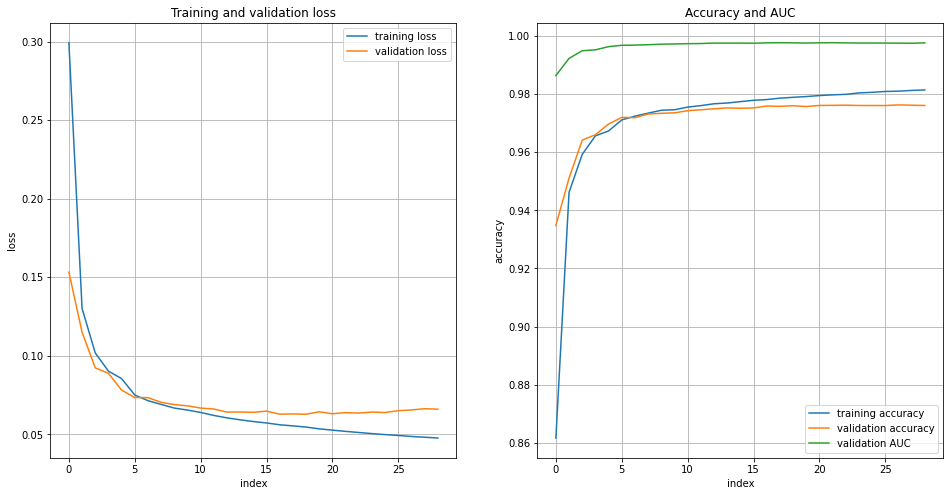

Starting attempt 2 in fold 4
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867790	0.291127	0.932600	0.167528	0.983541	0:00:27.139479
1	0.946785	0.134900	0.953133	0.118605	0.991735	0:00:49.540125
2	0.958389	0.108290	0.956978	0.112818	0.992491	0:01:11.284889
3	0.963005	0.095455	0.965322	0.089604	0.995221	0:01:33.294960
4	0.968065	0.082327	0.968256	0.080686	0.996095	0:01:55.166485
5	0.968433	0.082090	0.968622	0.082312	0.995779	0:02:16.977954
6	0.970936	0.076097	0.971578	0.074513	0.996495	0:02:39.421707
7	0.972678	0.071896	0.972544	0.072486	0.996674	0:03:01.320611
8	0.973502	0.068553	0.973367	0.069195	0.997030	0:03:23.265033
9	0.974400	0.065921	0.972878	0.069547	0.997120	0:03:45.153123
10	0.975237	0.063999	0.974689	0.065918	0.997291	0:04:06.767357
11	0.976000	0.062184	0.974244	0.067011	0.997243	0:04:29.155486
12	0.976362	0.060916	0.975100	0.065142	0.997390	0:04:50.975477
13	0.976744	0.059838	0.975289	0.064100	0.997445	0:05:12.845432
14	0.977236	0.058499	0.975144	0.06

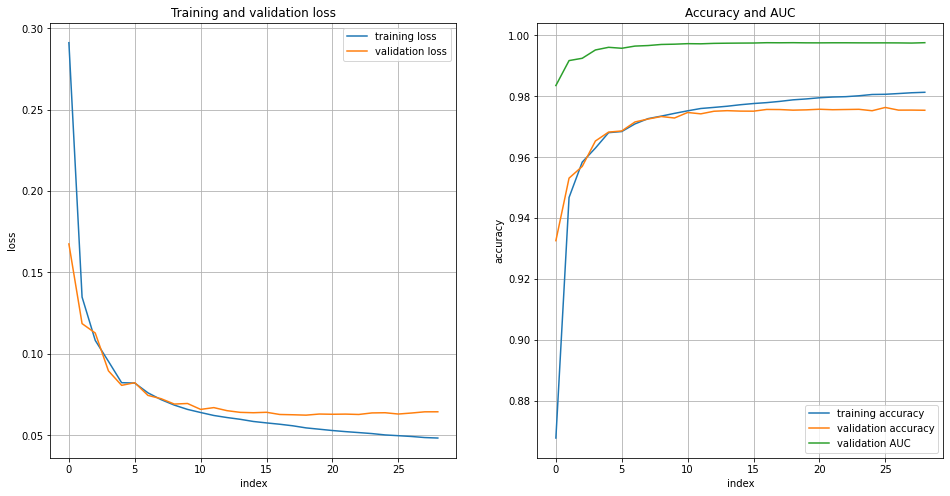

Performed fold 4 attempt 2
Starting fold 5
Starting attempt 0 in fold 5
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.861281	0.311572	0.935678	0.175041	0.981066	0:00:27.449615
1	0.948947	0.140574	0.954511	0.123262	0.990504	0:00:49.377244
2	0.949067	0.141209	0.949711	0.140715	0.987080	0:01:11.144405
3	0.956317	0.116070	0.962189	0.096656	0.994322	0:01:32.882828
4	0.964249	0.091620	0.967378	0.086008	0.995345	0:01:54.676425
5	0.968109	0.082525	0.969833	0.079339	0.996086	0:02:16.613344
6	0.969911	0.077260	0.970433	0.076485	0.996339	0:02:38.408358
7	0.971759	0.072883	0.971611	0.073534	0.996589	0:03:00.217619
8	0.972706	0.070581	0.971967	0.072841	0.996876	0:03:22.106209
9	0.973720	0.067861	0.973378	0.068568	0.997052	0:03:43.954359
10	0.974532	0.066022	0.972556	0.070896	0.997050	0:04:05.892715
11	0.975228	0.063995	0.974244	0.067379	0.997210	0:04:27.623846
12	0.975725	0.062524	0.974489	0.065683	0.997307	0:04:49.583044
13	0.975381	0.064399	0.974022	0.067191	0.997179	0:05:1

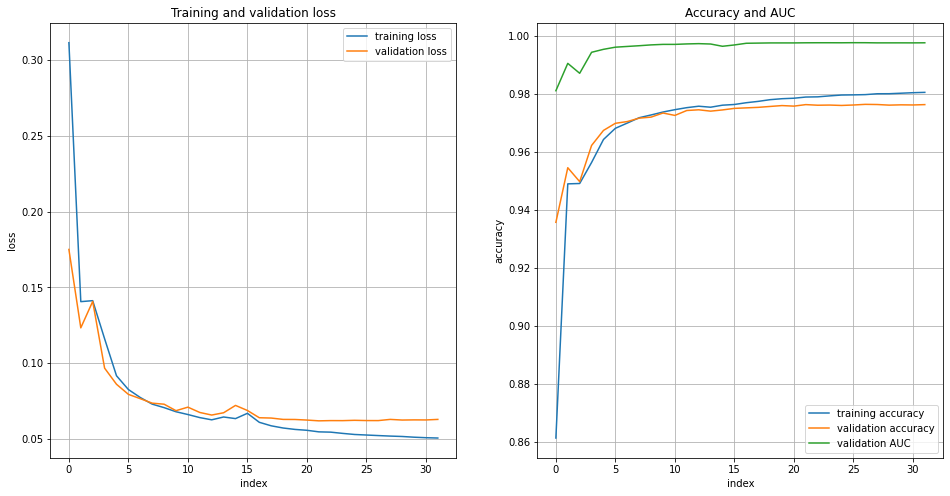

Starting attempt 1 in fold 5
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867218	0.301983	0.936800	0.168855	0.982113	0:00:27.779711
1	0.943036	0.151333	0.949111	0.131464	0.988962	0:00:49.576721
2	0.952204	0.121300	0.955156	0.117099	0.991460	0:01:11.540591
3	0.957289	0.108700	0.956756	0.109557	0.992945	0:01:33.311526
4	0.962333	0.095236	0.963733	0.091621	0.994793	0:01:55.157728
5	0.966386	0.085241	0.966922	0.085113	0.995524	0:02:17.281780
6	0.968410	0.080442	0.969467	0.079270	0.996143	0:02:39.051065
7	0.970356	0.075561	0.970167	0.077930	0.996183	0:03:01.058755
8	0.971715	0.072217	0.971433	0.074409	0.996550	0:03:22.838376
9	0.972604	0.070247	0.972244	0.072170	0.996755	0:03:44.539148
10	0.973293	0.067884	0.972511	0.070840	0.996870	0:04:06.285546
11	0.974095	0.066065	0.972200	0.071649	0.996796	0:04:28.062204
12	0.974470	0.064600	0.973489	0.068712	0.997112	0:04:49.891837
13	0.975362	0.062937	0.972444	0.070705	0.996988	0:05:11.678175
14	0.975807	0.061574	0.974056	0.06

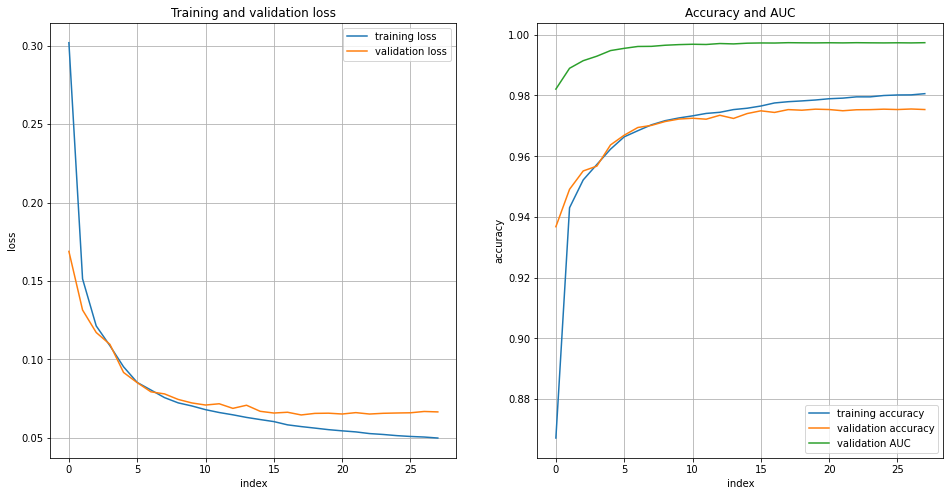

Starting attempt 2 in fold 5
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867923	0.305974	0.927222	0.193420	0.977366	0:00:27.178100
1	0.938515	0.160209	0.946200	0.138509	0.988003	0:00:48.992708
2	0.951823	0.124518	0.951333	0.124967	0.991105	0:01:10.770957
3	0.955202	0.117058	0.955922	0.114075	0.992572	0:01:32.585875
4	0.957783	0.109865	0.959333	0.103214	0.993409	0:01:54.165438
5	0.961790	0.098246	0.961244	0.098053	0.993964	0:02:16.072422
6	0.963904	0.092824	0.966033	0.088004	0.995107	0:02:37.832457
7	0.966189	0.086906	0.966667	0.085965	0.995383	0:02:59.783081
8	0.967849	0.083779	0.966578	0.088943	0.995320	0:03:21.561431
9	0.966104	0.086557	0.968678	0.080381	0.995951	0:03:43.386798
10	0.969186	0.077714	0.969367	0.077244	0.996470	0:04:05.593044
11	0.971549	0.071616	0.971544	0.071854	0.996830	0:04:27.469294
12	0.971427	0.074467	0.972056	0.077004	0.996129	0:04:49.177356
13	0.973247	0.070487	0.972367	0.073101	0.996665	0:05:10.980227
14	0.974183	0.066756	0.973511	0.06

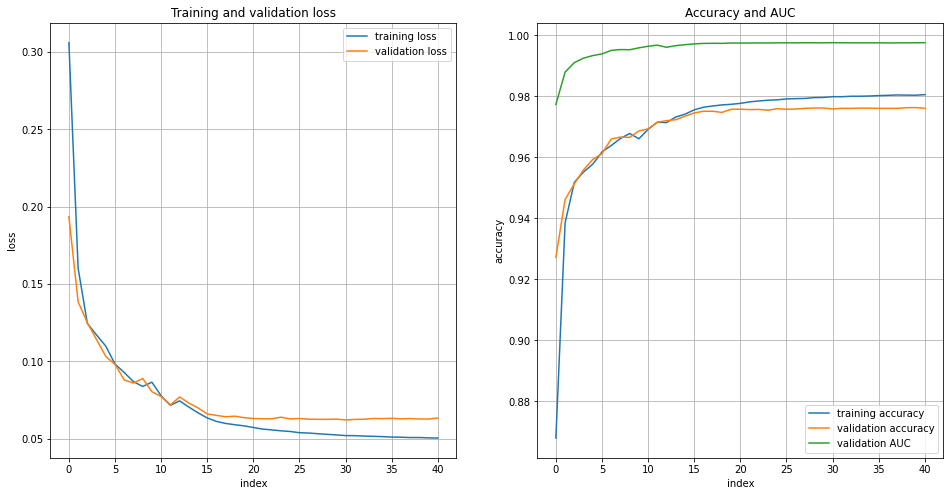

Performed fold 5 attempt 2
Starting fold 6
Starting attempt 0 in fold 6
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.871406	0.284966	0.937744	0.163733	0.983320	0:00:27.134112
1	0.946412	0.141008	0.953822	0.121396	0.990840	0:00:48.914458
2	0.950136	0.128326	0.958111	0.108816	0.992711	0:01:10.626629
3	0.958788	0.106982	0.961400	0.101879	0.993372	0:01:33.091125
4	0.962106	0.097503	0.965544	0.091502	0.994648	0:01:55.034499
5	0.965354	0.090285	0.966489	0.087852	0.995181	0:02:16.806891
6	0.968669	0.082875	0.969622	0.080131	0.996092	0:02:38.604011
7	0.971673	0.075483	0.974289	0.068754	0.997016	0:03:00.401708
8	0.973359	0.070409	0.974244	0.067784	0.997193	0:03:22.727981
9	0.974531	0.066700	0.974522	0.066603	0.997118	0:03:44.494216
10	0.975356	0.064281	0.976333	0.062543	0.997549	0:04:06.311415
11	0.975844	0.062757	0.975367	0.064124	0.997392	0:04:28.173959
12	0.976391	0.061285	0.976133	0.063075	0.997489	0:04:49.848694
13	0.977093	0.059452	0.976600	0.060979	0.997630	0:05:1

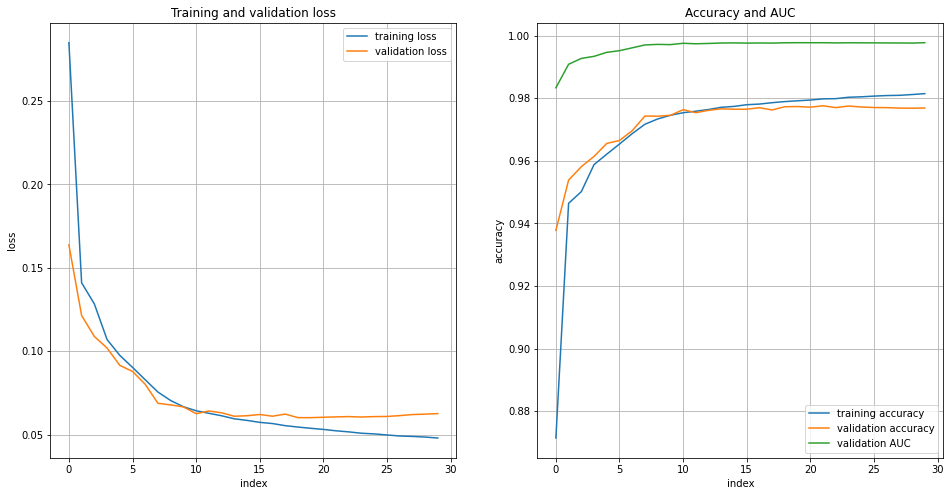

Starting attempt 1 in fold 6
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.870948	0.281320	0.940800	0.148652	0.986368	0:00:26.780207
1	0.947699	0.129405	0.955833	0.108653	0.992751	0:00:48.404021
2	0.956798	0.108408	0.959278	0.103974	0.993667	0:01:09.948906
3	0.964852	0.091179	0.967822	0.084375	0.995595	0:01:31.514675
4	0.967931	0.083477	0.968744	0.081271	0.995875	0:01:53.219404
5	0.970999	0.075647	0.972944	0.073022	0.996589	0:02:14.992508
6	0.971947	0.072591	0.972967	0.071065	0.996828	0:02:36.766685
7	0.973528	0.068545	0.974033	0.067577	0.997150	0:02:58.757531
8	0.974521	0.065792	0.974778	0.066220	0.997212	0:03:20.667424
9	0.975110	0.064398	0.974756	0.064640	0.997381	0:03:42.262700
10	0.975611	0.062648	0.975400	0.065140	0.997376	0:04:03.703235
11	0.976215	0.061369	0.976144	0.062437	0.997530	0:04:25.234320
12	0.976964	0.059823	0.975811	0.062664	0.997537	0:04:46.922073
13	0.977246	0.058876	0.975933	0.062127	0.997609	0:05:08.571879
14	0.977649	0.057439	0.975967	0.06

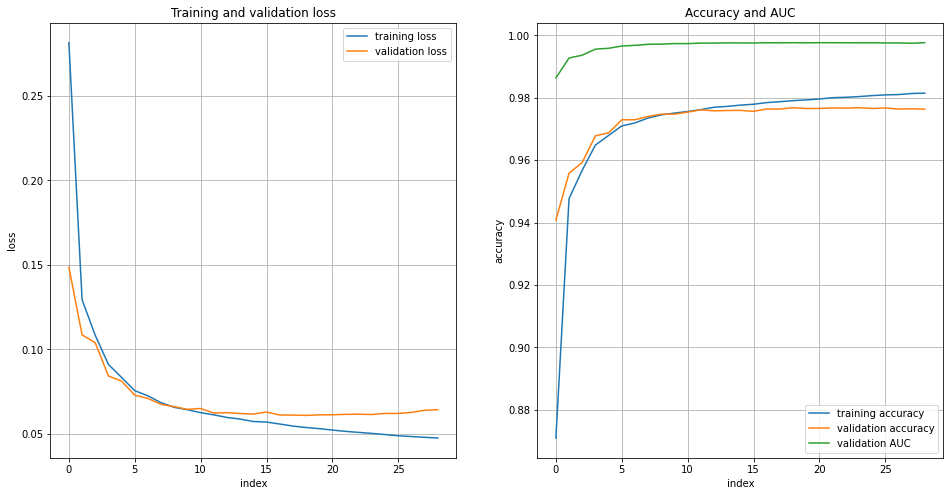

Starting attempt 2 in fold 6
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.851922	0.327647	0.928633	0.184669	0.978743	0:00:27.314837
1	0.936558	0.166888	0.951589	0.127762	0.989975	0:00:49.222224
2	0.949307	0.134255	0.942111	0.149568	0.987286	0:01:10.993019
3	0.952789	0.122734	0.960289	0.106433	0.992935	0:01:32.832413
4	0.959668	0.104454	0.963311	0.094598	0.994398	0:01:54.898283
5	0.962709	0.095784	0.960311	0.099529	0.994884	0:02:16.686630
6	0.964307	0.092158	0.961322	0.105936	0.993027	0:02:38.928533
7	0.965599	0.092373	0.969411	0.081489	0.995757	0:03:00.638280
8	0.969715	0.079094	0.971289	0.076061	0.996345	0:03:22.634695
9	0.971575	0.074624	0.972711	0.072088	0.996687	0:03:44.978925
10	0.972846	0.071136	0.973122	0.070650	0.996818	0:04:07.010313
11	0.973057	0.070603	0.972556	0.073811	0.996516	0:04:28.946933
12	0.973342	0.070411	0.974256	0.069677	0.996866	0:04:50.886587
13	0.973961	0.068947	0.973011	0.072295	0.996857	0:05:12.883004
14	0.974810	0.066885	0.975011	0.06

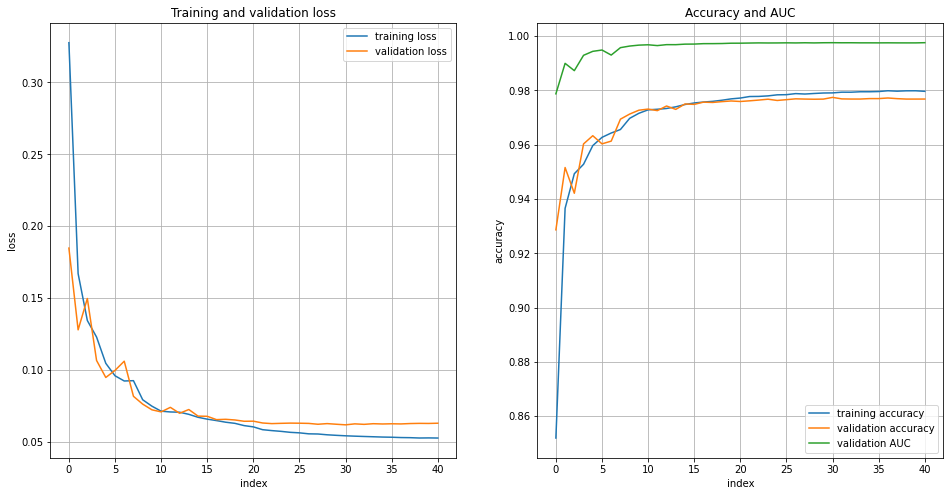

Performed fold 6 attempt 2
Starting fold 7
Starting attempt 0 in fold 7
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.842453	0.336454	0.925922	0.186004	0.978860	0:00:27.451936
1	0.935660	0.164481	0.946467	0.136056	0.989202	0:00:49.407418
2	0.956365	0.111657	0.960956	0.100592	0.993638	0:01:11.453032
3	0.962970	0.094898	0.965333	0.088934	0.995084	0:01:33.247459
4	0.967825	0.082681	0.966822	0.084971	0.995496	0:01:55.725886
5	0.970130	0.076971	0.970722	0.076567	0.996382	0:02:17.605960
6	0.971770	0.073102	0.971689	0.072498	0.996727	0:02:39.408584
7	0.972777	0.070165	0.973400	0.070392	0.996945	0:03:01.392841
8	0.973781	0.067965	0.973456	0.069674	0.996910	0:03:23.073827
9	0.974365	0.066275	0.973844	0.068573	0.997024	0:03:44.791061
10	0.975438	0.063654	0.974300	0.066634	0.997179	0:04:06.626480
11	0.976012	0.062430	0.975278	0.064326	0.997438	0:04:28.468481
12	0.976448	0.060973	0.975456	0.064284	0.997391	0:04:50.374085
13	0.976873	0.059645	0.975611	0.064128	0.997389	0:05:1

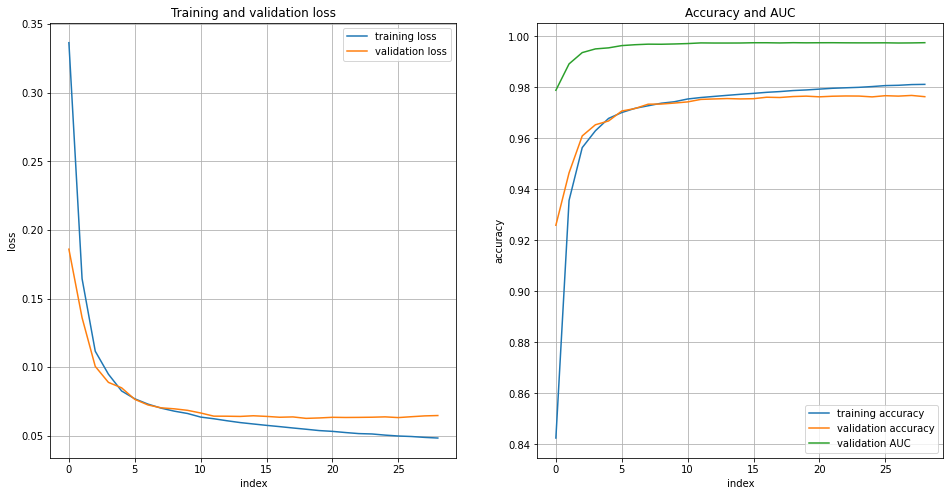

Starting attempt 1 in fold 7
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.869091	0.303921	0.925800	0.205591	0.974996	0:00:27.269203
1	0.939689	0.171335	0.942333	0.166275	0.982354	0:00:49.333857
2	0.932046	0.183015	0.939444	0.172882	0.981681	0:01:11.254550
3	0.948080	0.152017	0.953067	0.141329	0.987329	0:01:33.957000
4	0.955110	0.135167	0.956278	0.131084	0.988679	0:01:55.901956
5	0.958069	0.125403	0.958789	0.122175	0.990223	0:02:17.906269
6	0.960215	0.117588	0.961156	0.112532	0.991600	0:02:39.976411
7	0.961869	0.111137	0.961778	0.111883	0.991609	0:03:01.829855
8	0.962947	0.108066	0.962456	0.107811	0.992166	0:03:23.567008
9	0.963752	0.103928	0.962856	0.103157	0.993261	0:03:45.324888
10	0.964741	0.097326	0.963467	0.101192	0.993500	0:04:07.231459
11	0.965784	0.094379	0.965356	0.096870	0.994106	0:04:29.110991
12	0.966294	0.092555	0.966122	0.092074	0.994559	0:04:50.937977
13	0.967198	0.088704	0.966689	0.089472	0.995018	0:05:13.389024
14	0.968069	0.085992	0.966378	0.08

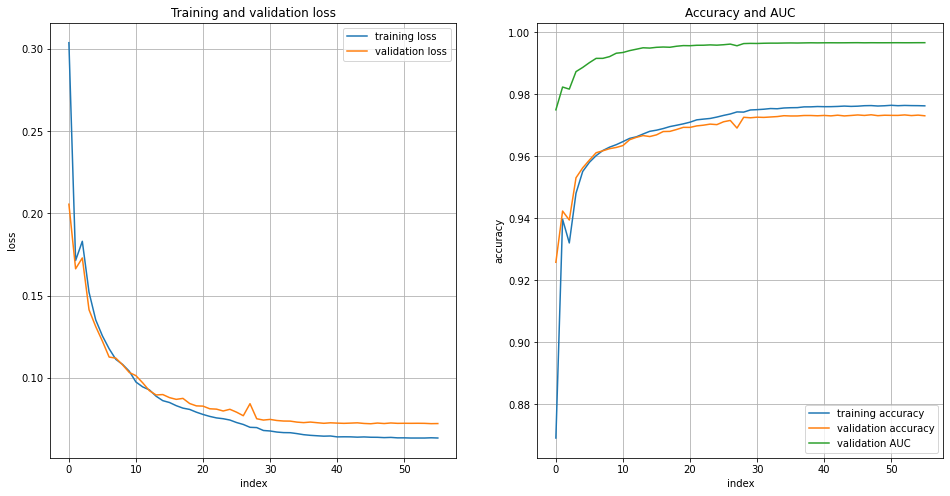

Starting attempt 2 in fold 7
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.854957	0.329336	0.904644	0.258969	0.959091	0:00:27.296806
1	0.934715	0.192654	0.947722	0.162484	0.983167	0:00:49.558955
2	0.950933	0.148941	0.950333	0.149766	0.985261	0:01:11.279937
3	0.950004	0.138987	0.956878	0.116158	0.991492	0:01:33.100014
4	0.961172	0.102488	0.962800	0.097235	0.994119	0:01:54.712226
5	0.965722	0.089376	0.966689	0.086949	0.995509	0:02:16.407246
6	0.968238	0.082603	0.968233	0.083615	0.995753	0:02:38.186198
7	0.969621	0.080056	0.968744	0.082399	0.995712	0:02:59.839999
8	0.970789	0.076346	0.971033	0.076061	0.996360	0:03:21.649133
9	0.972353	0.072242	0.971689	0.073934	0.996561	0:03:43.506197
10	0.973239	0.069788	0.973056	0.071967	0.996796	0:04:05.142201
11	0.973958	0.068215	0.973233	0.069455	0.997002	0:04:27.021172
12	0.974810	0.065007	0.974111	0.067303	0.997201	0:04:49.118129
13	0.975654	0.062772	0.974867	0.065793	0.997264	0:05:10.887089
14	0.975459	0.063592	0.973378	0.07

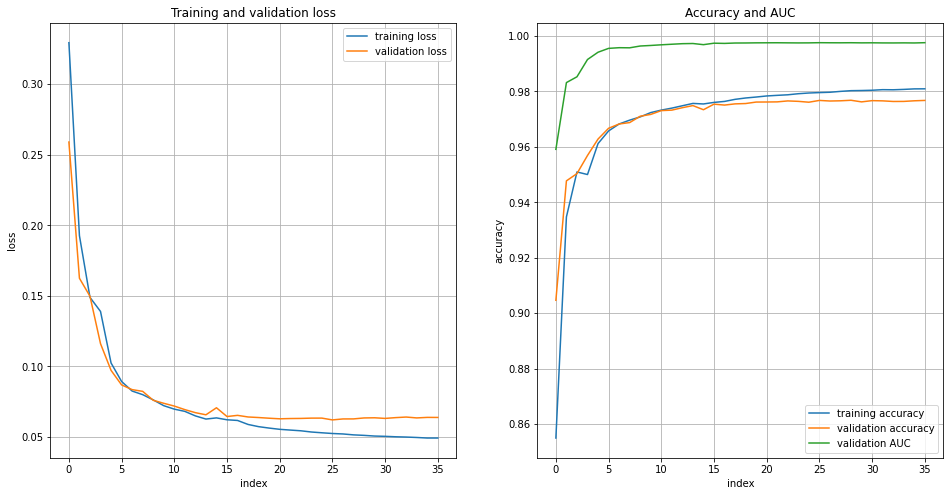

Performed fold 7 attempt 2
Starting fold 8
Starting attempt 0 in fold 8
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.855662	0.312088	0.929878	0.174043	0.982592	0:00:27.868848
1	0.942572	0.142407	0.946867	0.129776	0.989729	0:00:49.689268
2	0.951306	0.120445	0.959411	0.100626	0.993802	0:01:11.383126
3	0.959310	0.100585	0.960944	0.096459	0.994532	0:01:33.092517
4	0.964179	0.090141	0.967800	0.082962	0.995724	0:01:55.023591
5	0.968678	0.080818	0.970444	0.077003	0.996312	0:02:17.406364
6	0.966970	0.085081	0.970567	0.076879	0.996320	0:02:39.296406
7	0.971919	0.072562	0.973300	0.070878	0.996846	0:03:01.178214
8	0.973364	0.068592	0.973556	0.069198	0.997110	0:03:23.026806
9	0.974310	0.066271	0.973789	0.067815	0.997171	0:03:44.716204
10	0.975186	0.063958	0.974578	0.066179	0.997248	0:04:06.572624
11	0.975786	0.062713	0.974956	0.064878	0.997340	0:04:28.365120
12	0.976348	0.061276	0.974844	0.065080	0.997342	0:04:50.288666
13	0.976831	0.059573	0.975678	0.063331	0.997473	0:05:1

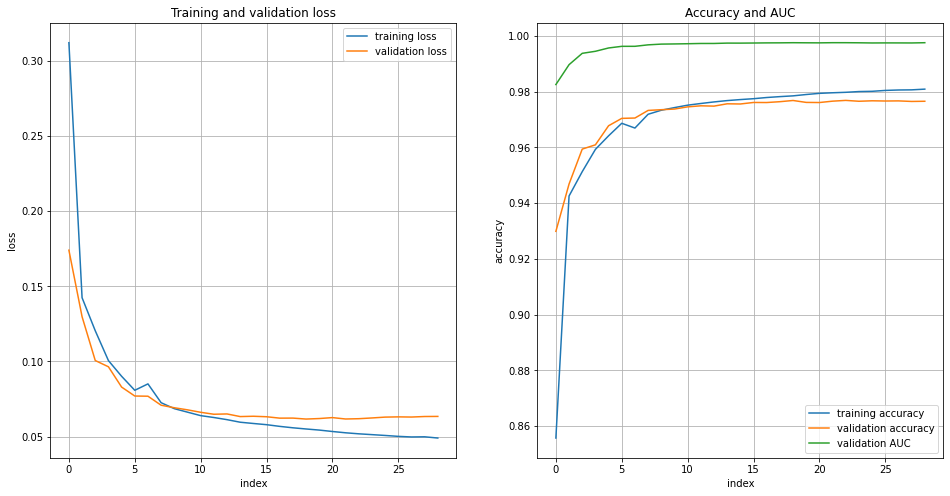

Starting attempt 1 in fold 8
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.849451	0.326881	0.933133	0.179983	0.980022	0:00:27.415553
1	0.915365	0.223915	0.930500	0.192898	0.976537	0:00:49.118172
2	0.938284	0.169142	0.942944	0.154958	0.985307	0:01:10.723408
3	0.949443	0.140587	0.953489	0.128056	0.989563	0:01:32.408771
4	0.951856	0.134207	0.954644	0.127999	0.989113	0:01:54.181752
5	0.953984	0.128785	0.954767	0.126905	0.989511	0:02:15.866163
6	0.957396	0.118091	0.959333	0.113385	0.991655	0:02:37.560157
7	0.961012	0.104176	0.961411	0.101645	0.993399	0:02:59.163956
8	0.962637	0.098961	0.962711	0.099145	0.993796	0:03:20.780538
9	0.964889	0.092231	0.966044	0.088237	0.995097	0:03:42.362770
10	0.966763	0.085072	0.964167	0.089903	0.995448	0:04:04.022414
11	0.965149	0.092019	0.963133	0.099314	0.993559	0:04:25.730968
12	0.958711	0.110142	0.965033	0.091284	0.994553	0:04:47.130377
13	0.960816	0.106364	0.963100	0.098562	0.993654	0:05:08.522986
14	0.966752	0.087741	0.966367	0.08

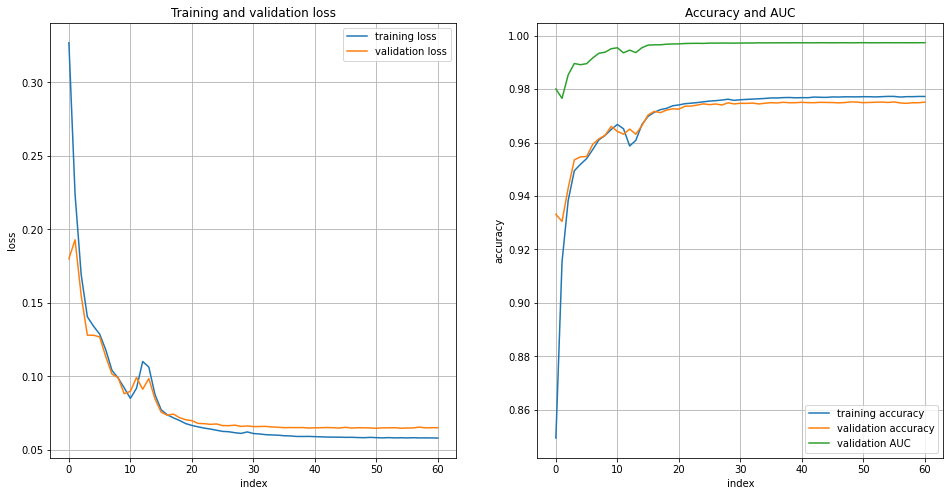

Starting attempt 2 in fold 8
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.853338	0.322896	0.933422	0.169787	0.982284	0:00:27.639903
1	0.927588	0.193671	0.944956	0.148130	0.986385	0:00:49.437533
2	0.947562	0.140390	0.954556	0.122413	0.990507	0:01:11.190537
3	0.953119	0.125362	0.954567	0.123328	0.990707	0:01:32.729602
4	0.956796	0.115175	0.958578	0.118407	0.990903	0:01:54.382917
5	0.955840	0.119496	0.959989	0.107221	0.992606	0:02:15.939794
6	0.961488	0.103165	0.963344	0.096609	0.994261	0:02:37.685764
7	0.963733	0.097917	0.962589	0.098773	0.994046	0:02:59.177276
8	0.962277	0.099634	0.965489	0.091340	0.994745	0:03:20.809530
9	0.965474	0.091446	0.967089	0.088238	0.995038	0:03:42.433394
10	0.966705	0.088142	0.962900	0.096897	0.994684	0:04:04.142753
11	0.967538	0.085984	0.968122	0.084805	0.995478	0:04:25.795170
12	0.967801	0.084957	0.968278	0.083947	0.995537	0:04:47.569945
13	0.966291	0.091351	0.967522	0.088742	0.995085	0:05:09.233972
14	0.968483	0.085498	0.968756	0.08

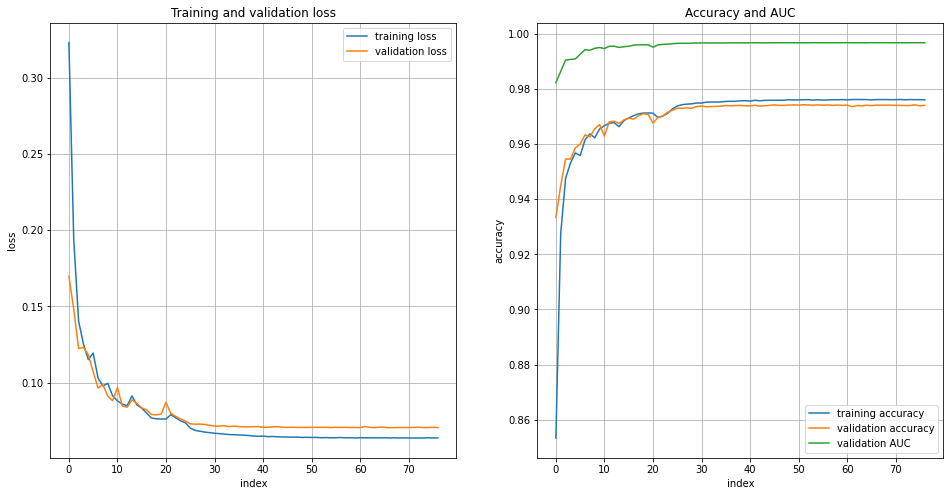

Performed fold 8 attempt 2
Starting fold 9
Starting attempt 0 in fold 9
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.837512	0.342470	0.928289	0.184251	0.979021	0:00:27.379225
1	0.942828	0.143735	0.952222	0.122164	0.991437	0:00:49.153524
2	0.957474	0.106797	0.960811	0.098602	0.993991	0:01:11.103215
3	0.963884	0.092134	0.966489	0.086811	0.995375	0:01:32.975384
4	0.967904	0.082796	0.969833	0.078495	0.996141	0:01:54.675182
5	0.970138	0.078027	0.970589	0.076186	0.996510	0:02:16.412038
6	0.972741	0.070815	0.974033	0.068782	0.997031	0:02:38.004061
7	0.973291	0.069589	0.973444	0.068525	0.997048	0:02:59.762558
8	0.974188	0.067535	0.973367	0.069438	0.997008	0:03:21.358854
9	0.975267	0.064607	0.974322	0.066967	0.997259	0:03:42.951534
10	0.975975	0.062024	0.975267	0.064158	0.997432	0:04:04.663104
11	0.976628	0.060532	0.974656	0.065008	0.997366	0:04:26.323468
12	0.976805	0.059746	0.975678	0.063025	0.997512	0:04:47.891381
13	0.977606	0.058044	0.975744	0.062340	0.997576	0:05:0

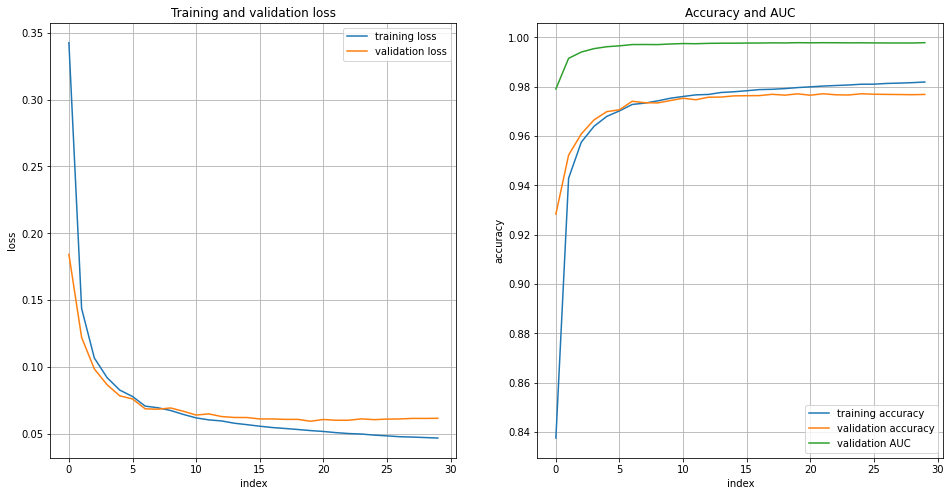

Starting attempt 1 in fold 9
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867578	0.291481	0.942067	0.153205	0.985320	0:00:26.838084
1	0.949521	0.132989	0.955633	0.115286	0.991650	0:00:48.617092
2	0.955464	0.117750	0.960100	0.107298	0.992592	0:01:10.321028
3	0.958920	0.108385	0.963744	0.097586	0.994038	0:01:31.990546
4	0.960519	0.104496	0.959133	0.106324	0.993134	0:01:53.828233
5	0.960963	0.103801	0.961144	0.103995	0.993278	0:02:15.492651
6	0.963735	0.097690	0.964733	0.095096	0.994355	0:02:37.129983
7	0.967194	0.088767	0.967733	0.085557	0.995324	0:02:58.721440
8	0.968972	0.083767	0.969078	0.082398	0.995620	0:03:20.476037
9	0.969317	0.083502	0.969600	0.082152	0.995669	0:03:42.229469
10	0.970202	0.080484	0.969789	0.079017	0.996023	0:04:03.775292
11	0.972036	0.074672	0.970900	0.076077	0.996294	0:04:25.502730
12	0.972709	0.072596	0.972144	0.073652	0.996490	0:04:47.017621
13	0.972846	0.072115	0.972322	0.073337	0.996532	0:05:08.756936
14	0.974415	0.068311	0.974678	0.06

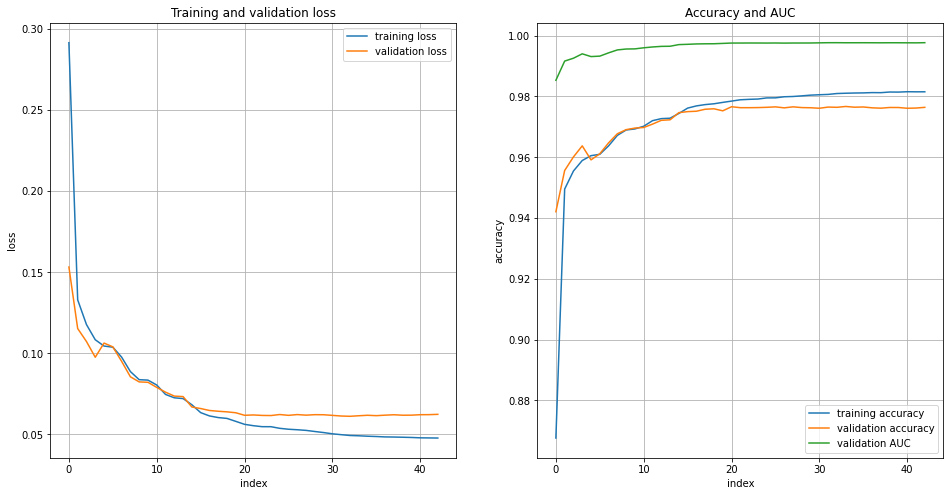

Starting attempt 2 in fold 9
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.859170	0.304736	0.926278	0.181276	0.980579	0:00:27.194727
1	0.935279	0.163639	0.943422	0.142226	0.987950	0:00:48.846722
2	0.949362	0.130768	0.954744	0.116326	0.991791	0:01:10.625108
3	0.957598	0.109121	0.960033	0.104703	0.993178	0:01:32.834452
4	0.961801	0.100091	0.963589	0.094881	0.994475	0:01:54.541412
5	0.966548	0.086302	0.968122	0.084241	0.995541	0:02:16.107910
6	0.970207	0.077444	0.971000	0.074928	0.996483	0:02:37.918865
7	0.972089	0.072471	0.958600	0.117725	0.992603	0:02:59.974884
8	0.969806	0.078240	0.971356	0.075926	0.996590	0:03:21.630860
9	0.972677	0.071355	0.972956	0.070791	0.996848	0:03:43.443747
10	0.974317	0.066994	0.974711	0.066353	0.997245	0:04:05.172847
11	0.975220	0.064285	0.974622	0.066908	0.997227	0:04:26.887528
12	0.975807	0.063055	0.975600	0.064791	0.997362	0:04:48.578513
13	0.976557	0.061066	0.974800	0.064764	0.997379	0:05:10.246106
14	0.976798	0.059892	0.975933	0.06

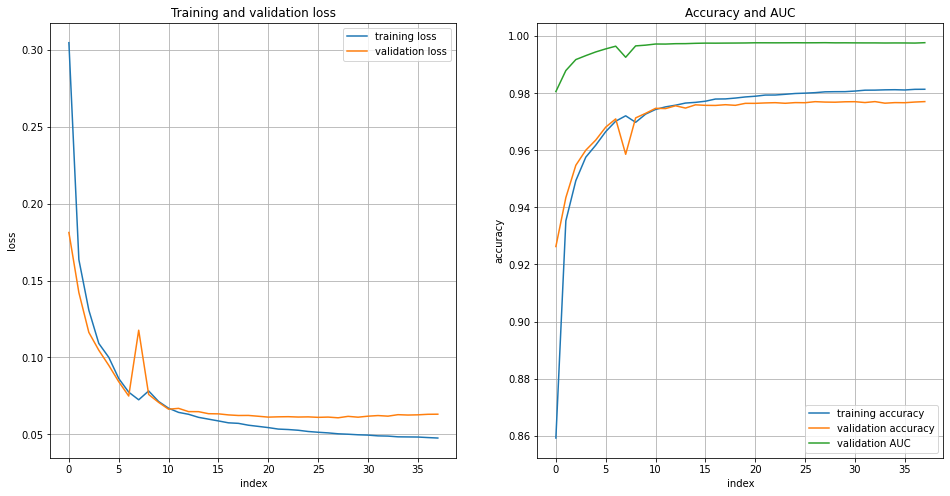

Performed fold 9 attempt 2
Performed in 7:40:03.222439


In [44]:
N_ATTEMPTS_PER_FOLD=3

# level 0 loop for folds
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)
    
    # nested loop for attempts within each fold
    # each attempt operates on the same data
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"tabnet_checkpoints/{idx}_{attempt}/"
        tf.keras.backend.clear_session()

        lr = DecayWithWarmupSchedule(
            learning_rate=params['initial_learning_rate'],
            warmup=params['num_warmup_epochs'],
            decay_rate=params['lr_decay_rate'],
            decay_steps=params['decay_steps'],
            min_learning_rate=params['min_learning_rate']
        )
    
        model_tabnet_= TFTabnetClassifier(
            num_features=test_df.shape[1], 
            feature_dim=params['tabnet_feature_dim'], 
            output_dim=params['tabnet_output_dim'],
            n_classes=2, 
            n_step=params['tabnet_n_step'], 
            relaxation_factor=params['relaxation_factor'],
            bn_momentum=params['tabnet_bn_momentum'], 
            dp=params['tabnet_dp'], 
            bn_virtual_divider=params['tabnet_bn_virtual_divider'],
            output_activation='softmax'
        )

        model_tabnet_.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr,clipnorm=params['adam_clipnorm']),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')],
        )
        auc_callback = AUCCallback(validation_data=X_val_fold_scaled.values, validation_labels=folds[idx]['y_val'])
        model_tabnet_.fit(
            X_train_fold_scaled.values, folds[idx]['y_train'],
            validation_data=(X_val_fold_scaled.values, folds[idx]['y_val']),
            callbacks=[
                EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-6, patience=10, restore_best_weights=True),
                auc_callback,
                ModelCheckpoint(filepath=CHECKPOINTS_PATH, 
                    monitor="val_loss", 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode="min")
            ],
            verbose=0,
            batch_size=params['batch_size'], 
            epochs= params['max_epochs'])
    
        # load the best weights
        model_tabnet_.load_weights(CHECKPOINTS_PATH)
        folds_results[((idx, attempt), 'TabNet')]= model_tabnet_.predict(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results[((idx, attempt), 'TabNet')])
        folds_scores[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")
        plot_training_history(auc_callback.history)
    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

In [45]:
tf_tabnet_res__={
    "folds_scores": folds_scores,
    "folds": folds,
    "folds_val_predictions": folds_results,
}
with open("TFTabNetResults.pkl", "wb") as f:
    pickle.dump(tf_tabnet_res__,f)

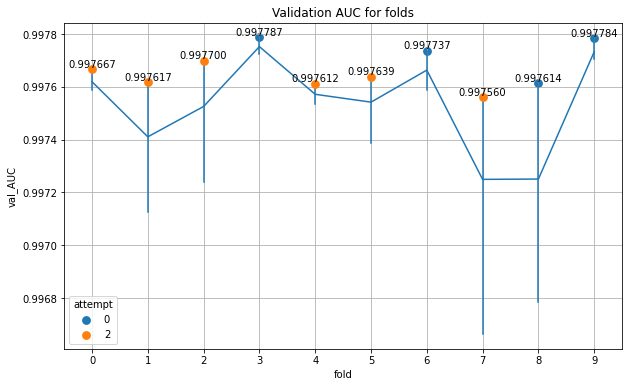

In [170]:
score_df=pd.DataFrame.from_dict(folds_scores, orient='index', columns=['val_AUC'])
score_df=score_df.reset_index()
score_df['fold']=score_df['attempt']=np.NaN
score_df['fold']=score_df['index'].apply(lambda x: x[0])
score_df['attempt']=score_df['index'].apply(lambda x: x[1])
score_df.sort_values(by=['fold','attempt']).reset_index()
score_df=score_df[['fold','attempt','val_AUC']]
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=score_df, x='fold', y='val_AUC',  ax=ax, err_style='bars')
score_df_best = score_df.loc[score_df.groupby('fold')['val_AUC'].idxmax()]
sns.pointplot(data=score_df_best, x='fold', y='val_AUC', hue='attempt', linestyles='', ax=ax)
for idx, fold, val in list(score_df_best[['fold', 'val_AUC']].itertuples()):
    ax.text(fold, val, f"{val:.6f}", horizontalalignment='center', verticalalignment='bottom')
    
ax.grid('both')
ax.set_title('Validation AUC for folds');


In [176]:
for fold, attempt, val in score_df_best.values:
    CHECKPOINTS_PATH=f"tabnet_checkpoints/{int(fold)}_{int(attempt)}/"
    print(CHECKPOINTS_PATH)
    model_tabnet_.load_weights(CHECKPOINTS_PATH)
    ss.fit(folds[fold]['X_train'])
    x_val_fold_scaled=ss.transform(folds[fold]['X_val'])
    folds_results[(fold, 'TabNet')]= model_tabnet_.predict(x_val_fold_scaled)[:,1]
    test_df_=ss.transform(test_df)
    test_predictions[fold]=model_tabnet_.predict(test_df_)[:,1]

tabnet_checkpoints/0_2/
tabnet_checkpoints/1_2/
tabnet_checkpoints/2_2/
tabnet_checkpoints/3_0/
tabnet_checkpoints/4_2/
tabnet_checkpoints/5_2/
tabnet_checkpoints/6_0/
tabnet_checkpoints/7_2/
tabnet_checkpoints/8_0/
tabnet_checkpoints/9_0/


<AxesSubplot:>

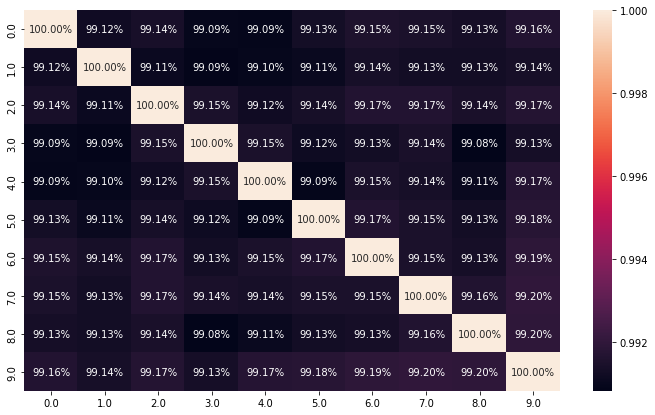

In [177]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [178]:
with open("TFTabNetResults_test_preds_1.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [179]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_TFTabNet_AttemptSelection.csv")

- This submission scored 0.99811 on public leaderboard when no attempt selection was performed (for each foild only single attempt was performed)
- With attempt selection publi score is 0.99810.

> **Conclusion - selecting attempt (local optimization among several results for the same fold train data does not introduce any improvement)**


# Tabnet Torch prediction

- Tabnet Torch implementation by DreamQuark-ai <a href=https://github.com/dreamquark-ai/tabnet>TabNet : Attentive Interpretable Tabular Learning </a>
- Paper: <a href=https://arxiv.org/ftp/arxiv/papers/2104/2104.13638.pdf>PyTorch Tabular: A Framework for Deep Learning with Tabular Data</a>

In [12]:
with open("TFTabNetResults.pkl", "rb") as f:
    tf_tabnet_res__ = pickle.load(f)

folds=tf_tabnet_res__['folds']

## Params definition

In [13]:
# The parameters were determined using 40 iterations of simulated anneal algorithm

params = {
  "max_epochs": 1000,
  "validation_fraction": 0.1,
  "early_stopping_rounds": 10,
  "tabnet_nd_na": 72,
  "tabnet_n_steps": 4,
  "tabnet_gamma": 1,
  "tabnet_n_independent": 3,
  "tabnet_n_shared": 3,
  "tabnet_momentum": 0.13130658137495604,
  "lambda_sparse": 0.005663888055050842,
  "tabnet_optimizer_lr": 0.015288556896304952,
  "tabnet_mask_type": "entmax",
  "pretraining_ratio": 0.5138208657762862,
  "batch_size": 4096
}

## CV folds training

In [14]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results_t = dict()
test_predictions_t=dict()
val_predictions_t=dict()
folds_scores_t={}

### Training loop

In [15]:
N_ATTEMPTS_PER_FOLD=1
start=dt.datetime.now()
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)  
    
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"tabnettorch_checkpoints/{idx}_{attempt}/"

        model =  TorchTabnetClassifier(
            n_d = params['tabnet_nd_na'],
            n_a = params['tabnet_nd_na'],
            n_steps = params['tabnet_n_steps'],
            gamma = params['tabnet_gamma'],
            n_independent= params['tabnet_n_independent'],
            n_shared = params['tabnet_n_shared'],
            momentum = params['tabnet_momentum'],
            lambda_sparse = params['lambda_sparse'],
            optimizer_fn = torch.optim.Adam,
            optimizer_params={'lr':params['tabnet_optimizer_lr']},
            mask_type = params['tabnet_mask_type']
        )        

        model.fit(
            X_train_fold_scaled.values, folds[idx]['y_train'],
            eval_set=[(X_val_fold_scaled.values, folds[idx]['y_val'])],
            batch_size=params['batch_size'],
            virtual_batch_size=128,
            max_epochs=params['max_epochs'],
            patience=params['early_stopping_rounds']
        )
        
        folds_results_t[((idx, attempt), 'TabNetTorch')]= model.predict_proba(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results_t[((idx, attempt), 'TabNetTorch')])
        folds_scores_t[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")    
        model.save_model(path=CHECKPOINTS_PATH+"torch_clf.zip")

    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

Starting fold 0
Starting attempt 0 in fold 0
Device used : cuda
epoch 0  | loss: 0.38257 | val_0_auc: 0.9812  |  0:00:26s
epoch 1  | loss: 0.16924 | val_0_auc: 0.9908  |  0:00:53s
epoch 2  | loss: 0.12901 | val_0_auc: 0.99398 |  0:01:19s
epoch 3  | loss: 0.1115  | val_0_auc: 0.9952  |  0:01:45s
epoch 4  | loss: 0.09986 | val_0_auc: 0.9961  |  0:02:12s
epoch 5  | loss: 0.09239 | val_0_auc: 0.99612 |  0:02:38s
epoch 6  | loss: 0.09844 | val_0_auc: 0.99382 |  0:03:04s
epoch 7  | loss: 0.09905 | val_0_auc: 0.99657 |  0:03:30s
epoch 8  | loss: 0.10452 | val_0_auc: 0.99571 |  0:03:56s
epoch 9  | loss: 0.09243 | val_0_auc: 0.99697 |  0:04:23s
epoch 10 | loss: 0.08391 | val_0_auc: 0.99716 |  0:04:49s
epoch 11 | loss: 0.08828 | val_0_auc: 0.99686 |  0:05:16s
epoch 12 | loss: 0.08173 | val_0_auc: 0.99699 |  0:05:43s
epoch 13 | loss: 0.08667 | val_0_auc: 0.99698 |  0:06:09s
epoch 14 | loss: 0.0791  | val_0_auc: 0.99709 |  0:06:36s
epoch 15 | loss: 0.08103 | val_0_auc: 0.99736 |  0:07:02s
epoch 16

In [16]:
# some iterations here were performed in the other script
# tyhe mean value is only for folds 0-6
score_df=pd.DataFrame.from_dict(folds_scores_t, orient='index')
print(f'Mean AUC: {score_df.mean()[0]:.6f} +/- {score_df.std()[0]:.6f}')


Mean AUC: 0.997448 +/- 0.000310


In [19]:

test_predictions=dict()
for idx in tqdm(folds.keys()):
    CHECKPOINTS_PATH=f"tabnettorch_checkpoints/{idx}_{attempt}/"
    model_tabnet_torch = TorchTabnetClassifier()
    model_tabnet_torch.load_model(CHECKPOINTS_PATH+"torch_clf.zip.zip")
    ss.fit(folds[idx]['X_train'])
    x_val_fold_scaled=ss.transform(folds[idx]['X_val'])
    folds_results_t[((idx, 0), 'TabNetTorch')]= model_tabnet_torch.predict_proba(x_val_fold_scaled)[:,1]
    
    test_df_=ss.transform(test_df)
    test_predictions[idx]=model_tabnet_torch.predict_proba(test_df_)[:,1]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Device used : cuda
Device used : cuda


 10%|████▍                                       | 1/10 [00:14<02:07, 14.16s/it]

Device used : cuda
Device used : cuda


 20%|████████▊                                   | 2/10 [00:28<01:52, 14.06s/it]

Device used : cuda
Device used : cuda


 30%|█████████████▏                              | 3/10 [00:42<01:38, 14.04s/it]

Device used : cuda
Device used : cuda


 40%|█████████████████▌                          | 4/10 [00:56<01:24, 14.02s/it]

Device used : cuda
Device used : cuda


 50%|██████████████████████                      | 5/10 [01:10<01:10, 14.12s/it]

Device used : cuda
Device used : cuda


 60%|██████████████████████████▍                 | 6/10 [01:24<00:56, 14.12s/it]

Device used : cuda
Device used : cuda


 70%|██████████████████████████████▊             | 7/10 [01:38<00:42, 14.09s/it]

Device used : cuda
Device used : cuda


 80%|███████████████████████████████████▏        | 8/10 [01:52<00:28, 14.09s/it]

Device used : cuda
Device used : cuda


 90%|███████████████████████████████████████▌    | 9/10 [02:06<00:14, 14.07s/it]

Device used : cuda
Device used : cuda


100%|███████████████████████████████████████████| 10/10 [02:20<00:00, 14.07s/it]


<AxesSubplot:>

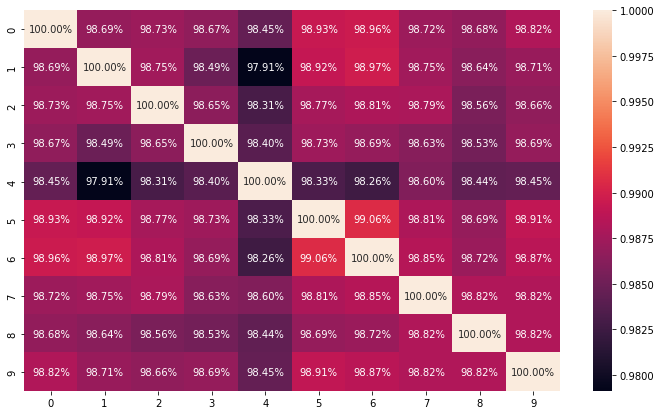

In [20]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [21]:
with open("TorchTabNetResults_test_preds_1.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [22]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_TorchTabNet_1.csv")

The result obtained is 0.99810 (Public)

# Results blending

In [24]:
tf_tabnet_csv=pd.read_csv("Finalsolution_data30_TFTabNet_AttemptSelection.csv")
pt_tabnet_csv=pd.read_csv("Finalsolution_data30_TorchTabNet_1.csv")
print(f"Predictions correlation: {pt_tabnet_csv['target'].corr(tf_tabnet_csv['target']):.4f}")

Predictions correlation: 0.9982


In [25]:
averaged=tf_tabnet_csv.join(pt_tabnet_csv["target"], rsuffix='pt')
averaged['target']=(averaged['target']+averaged['targetpt'])/2
averaged.set_index('id')['target'].to_csv('tabnet_averaged_prediction.csv')

This blending scored  0.99815

In [26]:
averaged=tf_tabnet_csv.join(pt_tabnet_csv["target"], rsuffix='pt')
averaged['target']=(2/3*averaged['target']+1/3*averaged['targetpt'])/2
averaged.set_index('id')['target'].to_csv('tabnet_averaged_prediction_03.csv')

This blending scored 0.99814

In [27]:
averaged=tf_tabnet_csv.join(pt_tabnet_csv["target"], rsuffix='pt')
averaged['target']=(0.75*averaged['target']+0.25*averaged['targetpt'])/2
averaged.set_index('id')['target'].to_csv('tabnet_averaged_prediction_025.csv')

This blending scored 0.99814